In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.xkcd()
import seaborn as sns
import datetime
from pymaran import gSheets
import io
import requests
from dateutil.rrule import rrule, MONTHLY

# Get Data

In [2]:
### Germany
de = pd.DataFrame(gSheets.readSheet("covidCrawlen").worksheet("data").get_all_values())
de.columns = de.iloc[0]
de = de[1:]

In [3]:
de.loc[de["city"] == "Nordrhein-West­falen", "city"] = "Nordrhein-Westfalen"
de.loc[de["city"] == "Rhein­land-Pfalz", "city"] = "Rheinland-Pfalz"
de.loc[de["city"] == "Schles­wig-Holstein", "city"] = "Schleswig Holstein"
de.loc[de["city"] == "Schleswig Holstein", "city"] = "Schleswig-Holstein"
de.loc[de["city"] == "Baden-Württem­berg", "city"] = "Baden-Wurttemberg"
de.loc[de["city"] == "Baden-Württemberg", "city"] = "Baden-Wurttemberg"
de.loc[de["city"] == "Mecklenburg-Vor­pommern", "city"] = "Mecklenburg-Vorpommern"
de.loc[de["city"] == "Mecklenburg-\nVor­pommern", "city"] = "Mecklenburg-Vorpommern"
de.loc[de["city"] == "Thüringen", "city"] = "Thuringen"
de.loc[de["city"] == "Gesamt", "city"] = "Total"

In [4]:
de["total_cases"] = pd.to_numeric(de["total_cases"])
de["old_date"] = pd.to_datetime(de["date"], format="%d/%m/%Y", errors="coerce")
de["new_date"] = pd.to_datetime(de["date"], format="%Y-%m-%d", errors="coerce")
de["date"] = de["old_date"].fillna(de["new_date"])
de.drop(columns=["old_date", "new_date"], inplace=True)

In [5]:
### World
url = "https://datahub.io/core/covid-19/r/time-series-19-covid-combined.csv"
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode("utf-8")))

In [6]:
c["Date"] = pd.to_datetime(c["Date"])
world = c.groupby(["Country/Region", "Date"])["Confirmed"].sum().reset_index()
world.columns = ["country", "date", "cases"]

## Process

In [7]:
def getAvg(x, days=7):
    global story
    story = []
    for i in range(days):
        if i is not np.NaN:
            story.append(x.shift(i)["growth"])

    # return np.mean([x[-1:].values for x in story])
    return pd.DataFrame([x[:] for x in story]).apply(lambda x: np.mean(x), axis=0)

In [8]:
def processCases(df, group="state", var="total_cases"):
    df = df.sort_values("date")
    day_data = df.groupby(group).apply(lambda x: x[[var]] - x.shift(1)[[var]])
    day_data.columns = ["growth"]
    active_data = df.groupby(group).apply(
        lambda x: x[[var]] - x.shift(14)[[var]].fillna(0)
    )
    active_data.columns = ["active cases"]
    df = df.join(day_data, rsuffix="_")
    df = df.join(
        pd.DataFrame(
            df.groupby(group).apply(lambda x: getAvg(x, 7)), columns=["avg growth"]
        )
        .reset_index()
        .set_index("level_1")
        .drop(group, axis=1)
    )
    df = df.join(active_data)
    return df

In [9]:
total = world.groupby("date")["cases"].sum().reset_index()
total["country"] = "World"

In [10]:
world = world.append(total).reset_index(drop=True)

In [14]:
de = processCases(de, "city")
world = processCases(world, "country", "cases")

In [15]:
de.columns = [
    "state",
    "total cases",
    "total deaths",
    "date",
    "growth",
    "avg growth",
    "active cases",
]
world.columns = [
    "country",
    "date",
    "total cases",
    "growth",
    "avg growth",
    "active cases",
]

In [16]:
countryList = [
    "Argentina",
    "Indonesia",
    "Mexico",
    "Finland",
    "New Zealand",
    "Australia",
    "Spain",
    "United Kingdom",
    "China",
    "US",
    "Iran",
    "Germany",
    "Brazil",
    "France",
    "Italy",
    "Korea, South",
]
stateList = [
    "Berlin",
    "Bayern",
    "Bremen",
    "Hamburg",
    "Hessen",
    "Thuringen",
    "Niedersachsen",
    "Total",
    "Nordrhein-Westfalen",
    "Baden-Wurttemberg",
]

In [18]:
w = world[world["country"].isin(countryList)]
w.sort_values(["country", "date"], inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
def datePlot(title, file, data, var="total cases", hue="country"):
    months = [
        dt
        for dt in rrule(
            MONTHLY, dtstart=data["date"].min().replace(day=1), until=data["date"].max()
        )
    ]
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title(title)
    sns.lineplot("date", var, hue=hue, data=data)
    ax.set_xticks(months)
    ax.set_xlim(data["date"].min(), data["date"].max() + datetime.timedelta(days=14))
    for i, ls in data.sort_values(var, ascending=False).groupby(hue).first().iterrows():
        ax.annotate(i, (ls["date"], ls[var]), clip_on=True)
    plt.savefig(file)

In [30]:
def linePlot(
    title, subtitle, file, data, x="total cases", y="avg growth", hue="country"
):

    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title(title)
    plt.suptitle(subtitle, fontsize=12, y=0, alpha=0.5)

    sns.lineplot(x, y, hue=hue, data=data)
    #    ax.set_xlim(data['date'].min(), data['date'].max() + datetime.timedelta(days=14))
    for i, ls in data.sort_values(y, ascending=False).groupby(hue).first().iterrows():
        ax.annotate(i, (ls[x], ls[y]), clip_on=True)
    plt.savefig(file)

In [20]:
def datePlotU(title, date, file, data, var="total cases", hue="country"):
    months = [
        dt
        for dt in rrule(
            MONTHLY, dtstart=data["date"].min().replace(day=1), until=data["date"].max()
        )
    ]
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title(title)
    plt.suptitle("(last updated " + str(date) + ")", fontsize=12, y=0, alpha=0.5)

    sns.lineplot("date", var, hue=hue, data=data)
    ax.set_xticks(months)
    ax.set_xlim(data["date"].min(), data["date"].max() + datetime.timedelta(days=14))
    for i, ls in data.sort_values(var, ascending=False).groupby(hue).first().iterrows():
        ax.annotate(i, (ls["date"], ls[var]), clip_on=True)
    plt.savefig(file)

In [39]:
def datePlotC(title, date, file, data, var="total cases", hue="country"):
    months = [
        dt
        for dt in rrule(
            MONTHLY, dtstart=data["date"].min().replace(day=1), until=data["date"].max()
        )
    ]
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.title(title)
    # plt.suptitle('(last updated '+ str(date) +')',fontsize=12, y=0, alpha=0.5)

    sns.lineplot("date", var, hue=hue, data=data)
    ax.set_xticks(months)
    ax.set_xlim(data["date"].min(), data["date"].max() + datetime.timedelta(days=14))
    for i, ls in data.sort_values(var, ascending=False).groupby(hue).first().iterrows():
        ax.annotate(i, (ls["date"], ls[var]), clip_on=True)
    ax.legend().remove()
    plt.savefig(file)

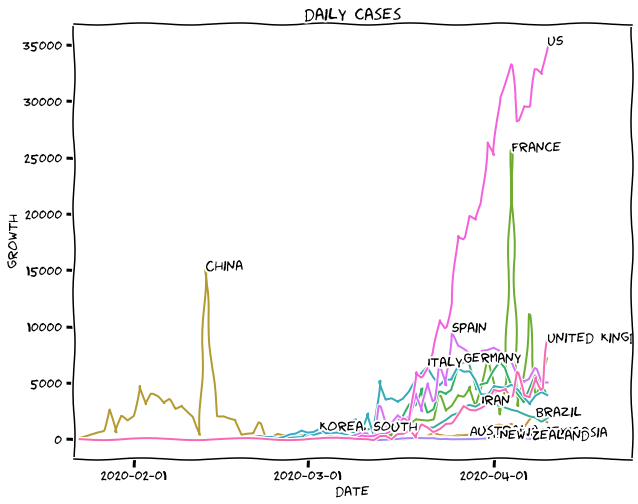

In [40]:
datePlotC("daily cases", "", "figs/cover.png", w, "growth")

In [21]:
def logPlot(
    title,
    file,
    data,
    hue="country",
    x="total cases",
    y="avg growth",
    autoLim=True,
    xlim=[10 ** 4, 10 ** 6.5],
    ylim=[10 ** 4, 10 ** 6.5],
    legend=True,
):

    fig, ax = plt.subplots(figsize=(13, 10))
    plt.title(title)

    sns.lineplot(x, y, hue=hue, sort=False, data=data)

    if autoLim:
        ax.set_xlim([10, data[x].max() * 10 ** 0.5])
        ax.set_ylim([10, data[y].max() * 10 ** 0.5])
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax.set_xscale("log")
    ax.set_yscale("log")

    if legend:
        ax.legend(loc="upper left")
    else:
        ax.legend().remove()

    for i, ls in data.groupby(hue).last().iterrows():
        ax.annotate(i, (ls[x], ls[y]), clip_on=True)

    plt.savefig(file)

In [22]:
def logPlotU(
    title,
    date,
    file,
    data,
    hue="country",
    x="total cases",
    y="avg growth",
    autoLim=True,
    xlim=[10 ** 4, 10 ** 6.5],
    ylim=[10 ** 4, 10 ** 6.5],
    legend=True,
):

    fig, ax = plt.subplots(figsize=(13, 10))
    plt.title(title)
    plt.suptitle("(last updated " + str(date) + ")", fontsize=12, y=0, alpha=0.5)

    sns.lineplot(x, y, hue=hue, sort=False, data=data)

    if autoLim:
        ax.set_xlim([10, data[x].max() * 10 ** 0.5])
        ax.set_ylim([10, data[y].max() * 10 ** 0.5])
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax.set_xscale("log")
    ax.set_yscale("log")

    if legend:
        ax.legend(loc="upper left")
    else:
        ax.legend().remove()

    for i, ls in data.groupby(hue).last().iterrows():
        ax.annotate(i, (ls[x], ls[y]), clip_on=True)

    plt.savefig(file)

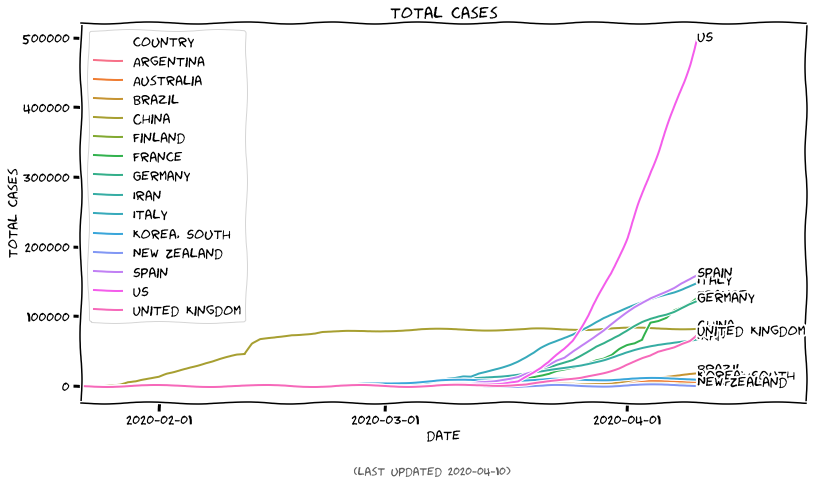

In [105]:
datePlotU("total cases", "2020-04-10", "figs/world-total.png", w)

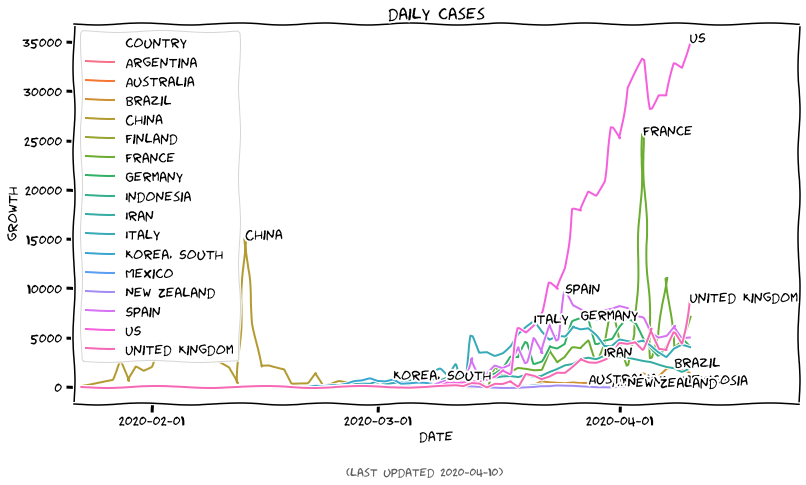

In [38]:
datePlotU("daily cases", "2020-04-10", "figs/world-daily.png", w, "growth")

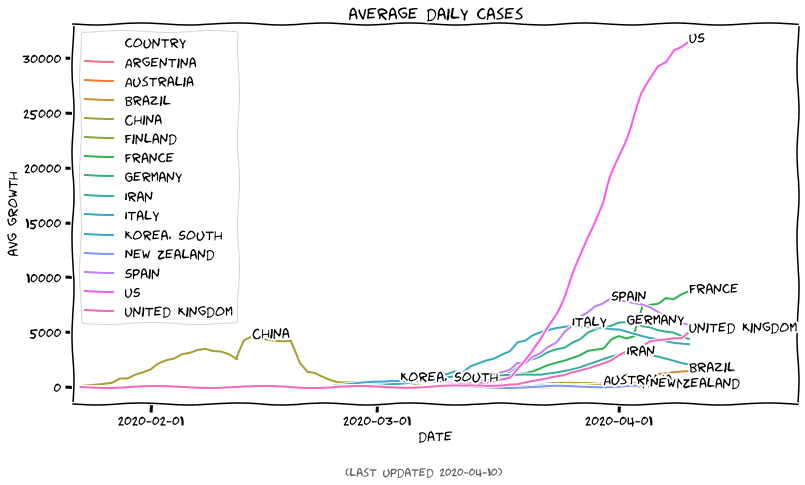

In [107]:
datePlotU("average daily cases", "2020-04-10", "figs/world-avg.png", w, "avg growth")

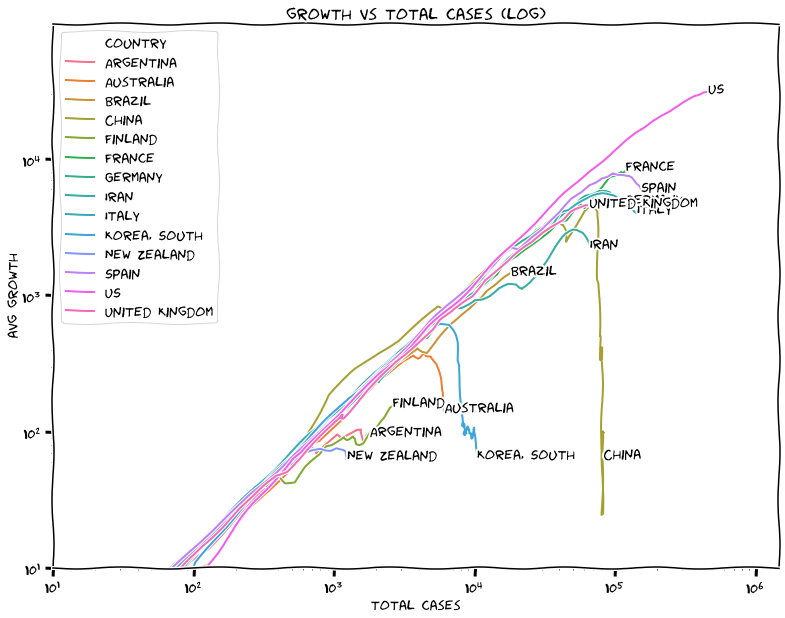

In [330]:
logPlot(
    "growth vs total cases (log)",
    "figs/world-log.png",
    w,
    "country",
    "total cases",
    "avg growth",
    True,
)

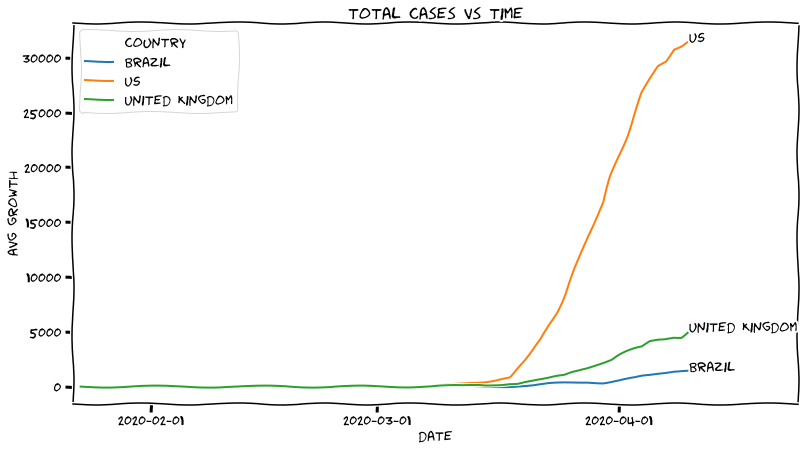

In [23]:
datePlot(
    "total cases vs time",
    "figs/comparison-date.png",
    w[w["country"].isin(["US", "Brazil", "United Kingdom"])],
    "avg growth",
)

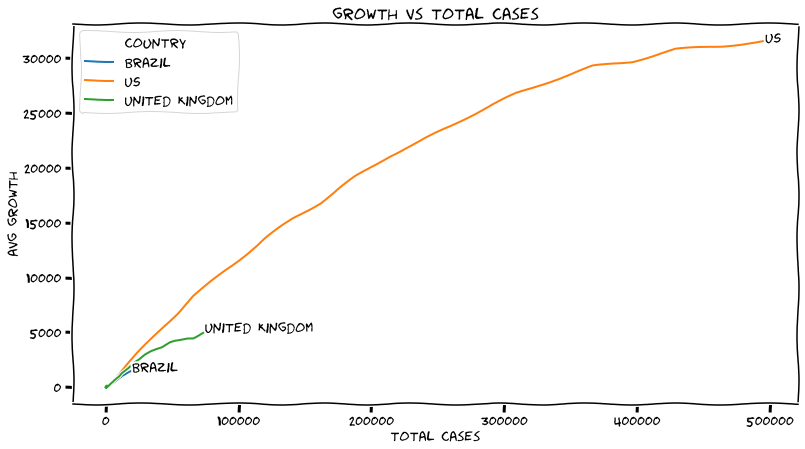

In [28]:
linePlot(
    "growth vs total cases",
    "figs/comparison-line.png",
    w[w["country"].isin(["US", "Brazil", "United Kingdom"])],
)

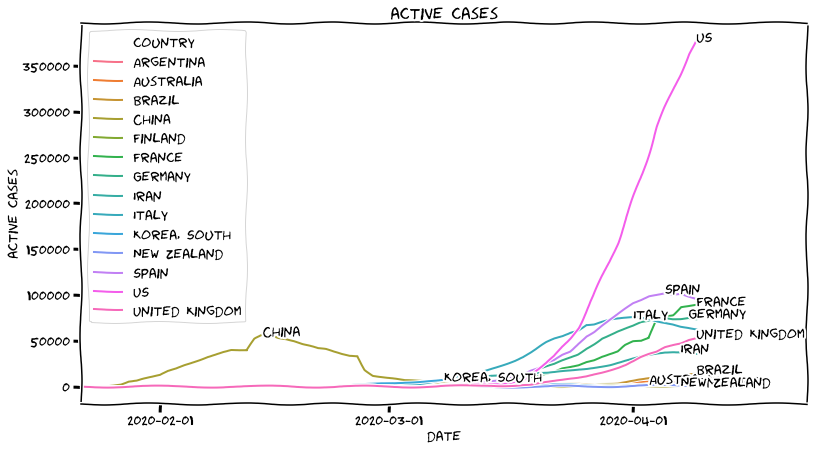

In [242]:
datePlot("active cases", "figs/world-active.png", w, "active cases")

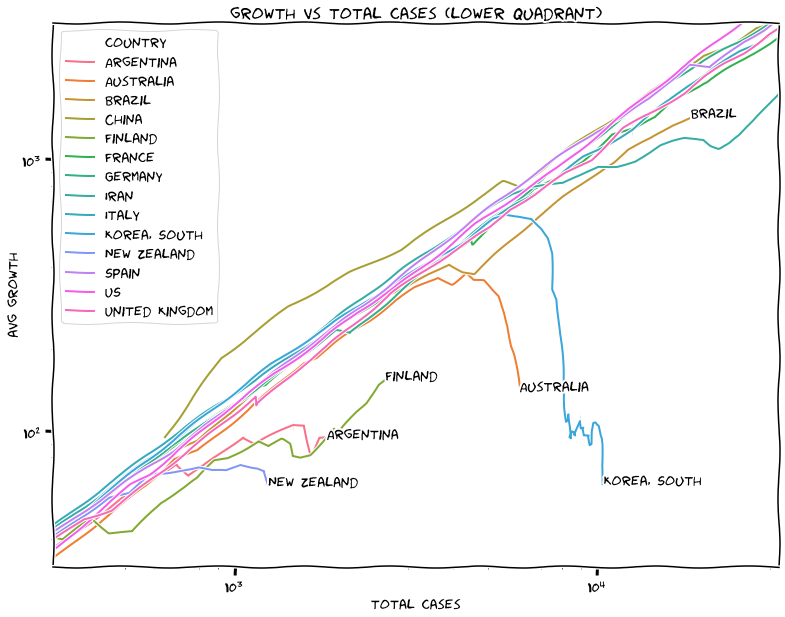

In [244]:
logPlot(
    "growth vs total cases (lower quadrant)",
    "figs/world-log-low.png",
    w,
    "country",
    "total cases",
    "avg growth",
    False,
    [10 ** 2.5, 10 ** 4.5],
    [10 ** 1.5, 10 ** 3.5],
)

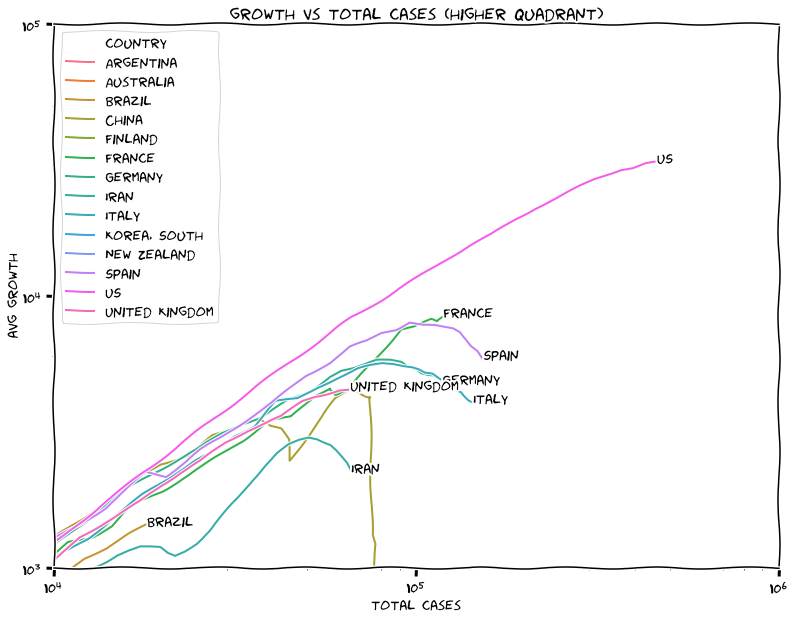

In [245]:
logPlot(
    "growth vs total cases (higher quadrant)",
    "figs/world-log-high.png",
    w,
    "country",
    "total cases",
    "avg growth",
    False,
    [10 ** 4, 10 ** 6],
    [10 ** 3, 10 ** 5],
)

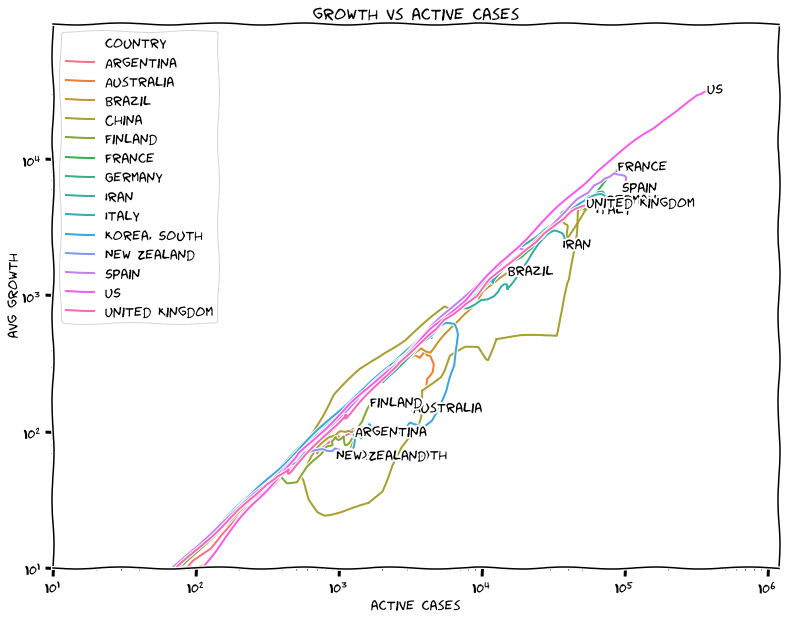

In [246]:
logPlot(
    "growth vs active cases",
    "figs/world-active-log.png",
    w,
    "country",
    "active cases",
    "avg growth",
    True,
)

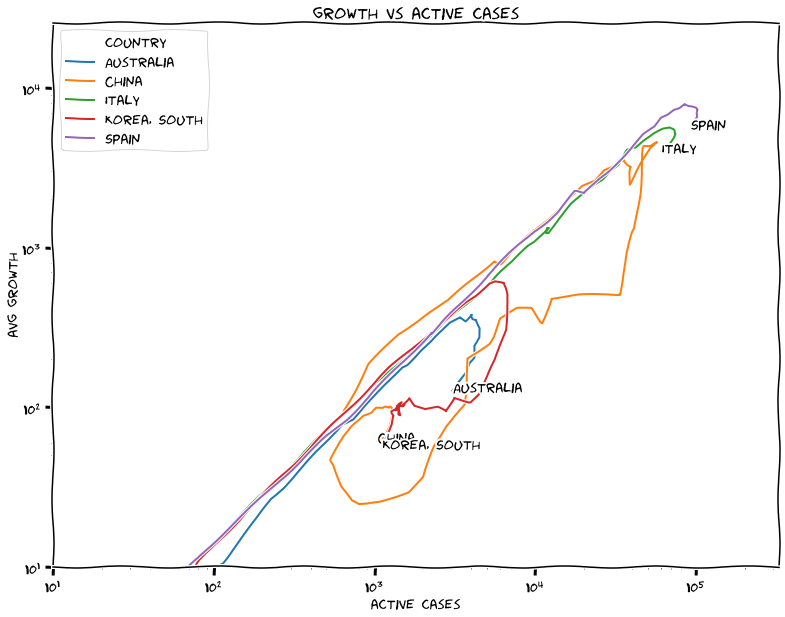

In [59]:
logPlot(
    "growth vs active cases",
    "figs/world-active-log-few.png",
    w[w["country"].isin(["Spain", "Italy", "China", "Australia", "Korea, South"])],
    "country",
    "active cases",
    "avg growth",
    True,
)

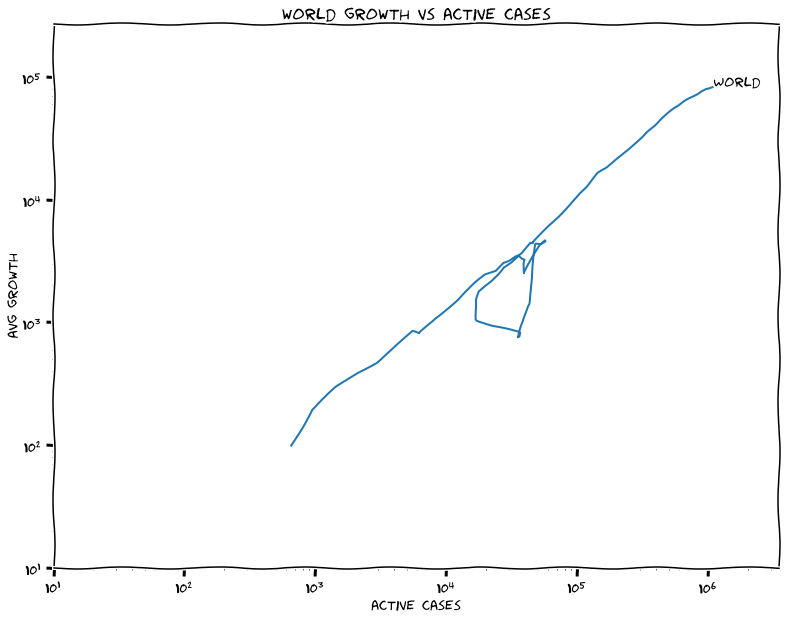

In [93]:
logPlot(
    "world growth vs active cases",
    "figs/total-active-log.png",
    world[world["country"] == "World"],
    "country",
    "active cases",
    "avg growth",
    True,
    "",
    "",
    False,
)

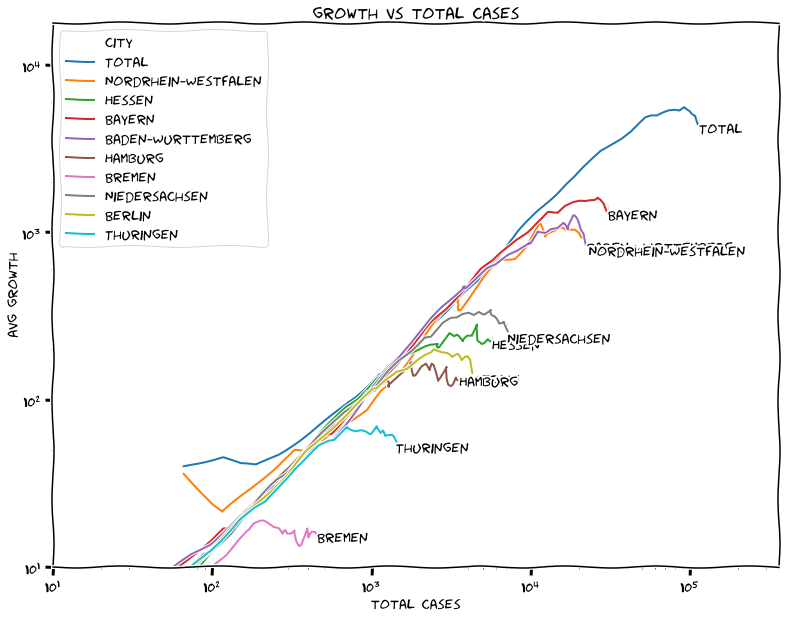

In [90]:
logPlot(
    "growth vs total cases",
    "figs/germany-total-log-few.png",
    de[de["state"].isin(stateList)],
    "state",
    "total cases",
    "avg growth",
    True,
)

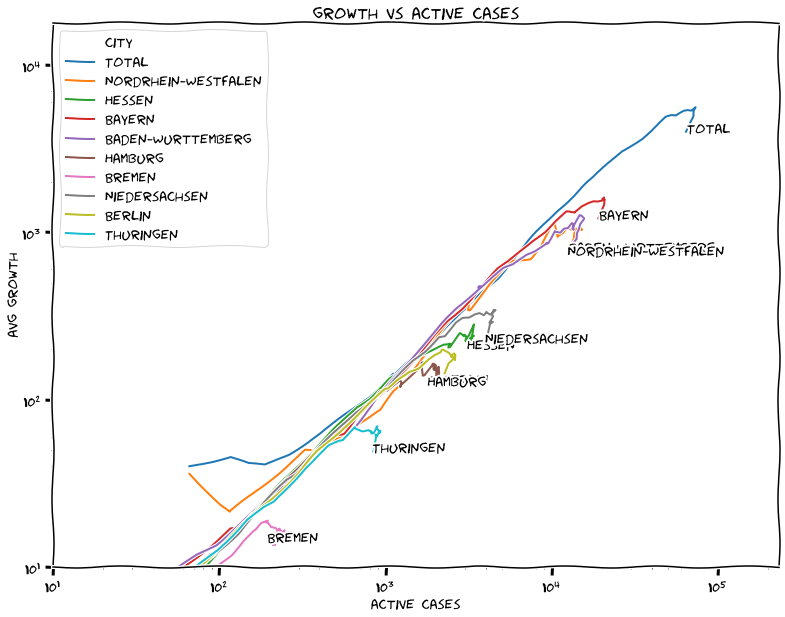

In [92]:
logPlot(
    "growth vs active cases",
    "figs/germany-active-log-few.png",
    de[de["state"].isin(stateList)],
    "state",
    "active cases",
    "avg growth",
    True,
)

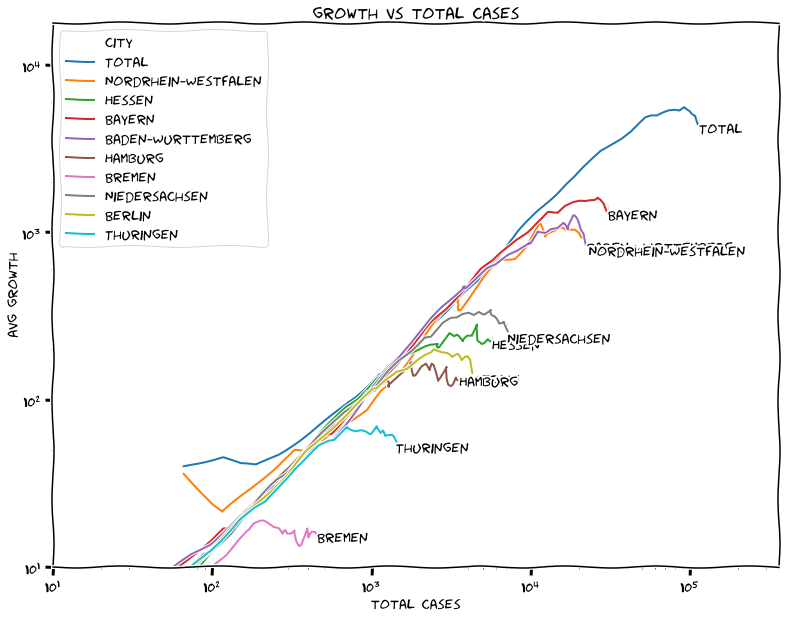

In [58]:
logPlot(
    "growth vs total cases",
    "figs/germany-total-log-few.png",
    de[de["state"].isin(stateList)],
    "state",
    "total cases",
    "avg growth",
    True,
)

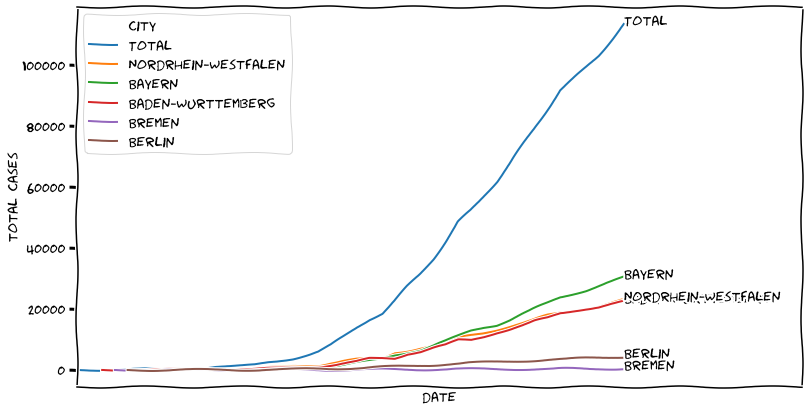

In [31]:
d = de[de["state"].isin(stateList)]
fig, ax = plt.subplots(figsize=(13, 7))
sns.lineplot("date", "total cases", hue="state", data=d)
ax.set_xticks([])
ax.set_xlim(d["date"].min(), d["date"].max() + datetime.timedelta(days=14))
for i, ls in d.groupby("state").last().iterrows():
    ax.annotate(i, (ls["date"], ls["total cases"]), clip_on=True)

In [345]:
de[de["state"] == "Berlin"].tail(20)  # ['avg growth'].mean()

city  total cases total deaths       date  growth  avg growth  \
331  Berlin         1024            1 2020-03-22   158.0  115.428571   
348  Berlin         1077            1 2020-03-23    53.0  116.000000   
365  Berlin         1220            1 2020-03-24   143.0  131.428571   
381  Berlin         1428            2 2020-03-25   208.0  148.142857   
398  Berlin         1656            4 2020-03-26   228.0  154.714286   
415  Berlin         1955           52 2020-03-27   299.0  174.857143   
432  Berlin         2161            8 2020-03-28   206.0  185.000000   
449  Berlin         2360            9 2020-03-29   199.0  190.857143   
466  Berlin         2464           11 2020-03-30   104.0  198.142857   
483  Berlin         2575           13 2020-03-31   111.0  193.571429   
500  Berlin         2754          179 2020-04-01   179.0  189.428571   
517  Berlin         2970          216 2020-04-02   216.0  187.714286   
534  Berlin         3202           20 2020-04-03   232.0  178.142857   
551  Berlin         3471           22 2020-04-04   269.0  187.142857   
568  Berlin         3613           24 2020-04-05   142.0  179.000000   
585  Berlin         3670           26 2020-04-06    57.0  172.285714   
602  Berlin         3845           28 2020-04-07   175.0  181.428571   
619  Berlin         4028           32 2020-04-08   183.0  182.000000   
636  Berlin         4188           37 2020-04-09   160.0  174.000000   
653  Berlin         4349           42 2020-04-10   161.0  163.857143   

     active cases  
331         996.0  
348        1037.0  
365        1172.0  
381        1380.0  
398        1566.0  
415        1818.0  
432        1987.0  
449        2144.0  
466        2199.0  
483        2275.0  
500        2363.0  
517        2397.0  
534        2471.0  
551        2605.0  
568        2589.0  
585        2593.0  
602        2625.0  
619        2600.0  
636        2532.0  
653        2394.0

In [96]:
w["days to double"] = w["total cases"] / w["avg growth"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


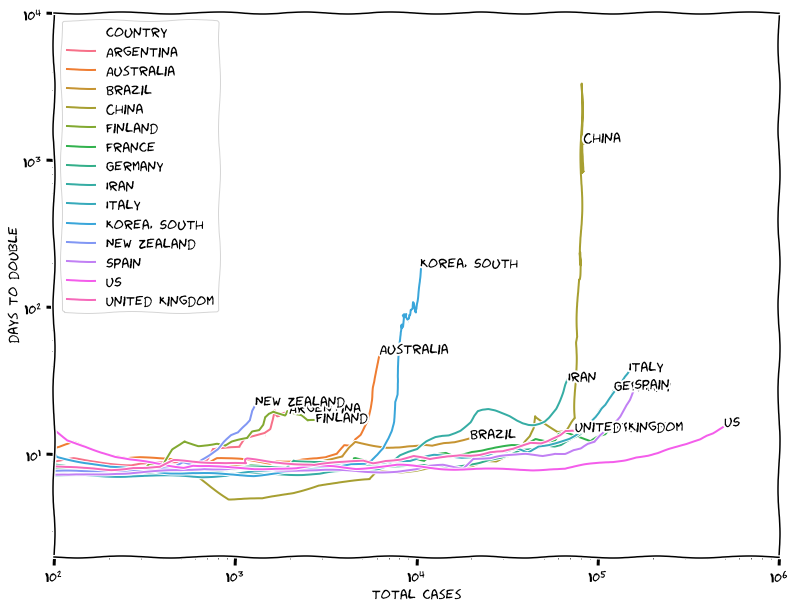

In [102]:
logPlot(
    "",
    "1",
    w[(w["days to double"] != 0) & (w["avg growth"] != 0)],
    "country",
    "total cases",
    "days to double",
    False,
    [100, 10 ** 6],
    [2, 10 ** 4],
)

In [327]:
w[w["country"] == "France"].tail(30)

country       date  total cases   growth   avg growth  active cases
4868  France 2020-03-11       2293.0    499.0   286.428571        2275.0
4869  France 2020-03-12       2293.0      0.0   273.285714        2255.0
4870  France 2020-03-13       3681.0   1388.0   432.142857        3624.0
4871  France 2020-03-14       4496.0    815.0   505.285714        4396.0
4872  France 2020-03-15       4532.0     36.0   485.142857        4402.0
4873  France 2020-03-16       6683.0   2151.0   780.571429        6492.0
4874  France 2020-03-17       7715.0   1032.0   845.857143        7511.0
4875  France 2020-03-18       9124.0   1409.0   975.857143        8836.0
4876  France 2020-03-19      10970.0   1846.0  1239.571429       10590.0
4877  France 2020-03-20      12758.0   1788.0  1296.714286       12102.0
4878  France 2020-03-21      14463.0   1705.0  1423.857143       13504.0
4879  France 2020-03-22      16243.0   1780.0  1673.000000       15107.0
4880  France 2020-03-23      20123.0   3880.0  1920.000000       18904.0
4881  France 2020-03-24      22622.0   2499.0  2129.571429       20828.0
4882  France 2020-03-25      25600.0   2978.0  2353.714286       23307.0
4883  France 2020-03-26      29551.0   3951.0  2654.428571       27258.0
4884  France 2020-03-27      33402.0   3851.0  2949.142857       29721.0
4885  France 2020-03-28      38105.0   4703.0  3377.428571       33609.0
4886  France 2020-03-29      40708.0   2603.0  3495.000000       36176.0
4887  France 2020-03-30      45170.0   4462.0  3578.142857       38487.0
4888  France 2020-03-31      52827.0   7657.0  4315.000000       45112.0
4889  France 2020-04-01      57749.0   4922.0  4592.714286       48625.0
4890  France 2020-04-02      59929.0   2180.0  4339.714286       48959.0
4891  France 2020-04-03      65202.0   5273.0  4542.857143       52444.0
4892  France 2020-04-04      90848.0  25646.0  7534.714286       76385.0
4893  France 2020-04-05      93773.0   2925.0  7580.714286       77530.0
4894  France 2020-04-06      98963.0   5190.0  7684.714286       78840.0
4895  France 2020-04-07     110065.0  11102.0  8176.857143       87443.0
4896  France 2020-04-08     113959.0   3894.0  8030.000000       88359.0
4897  France 2020-04-09     118781.0   4822.0  8407.428571       89230.0

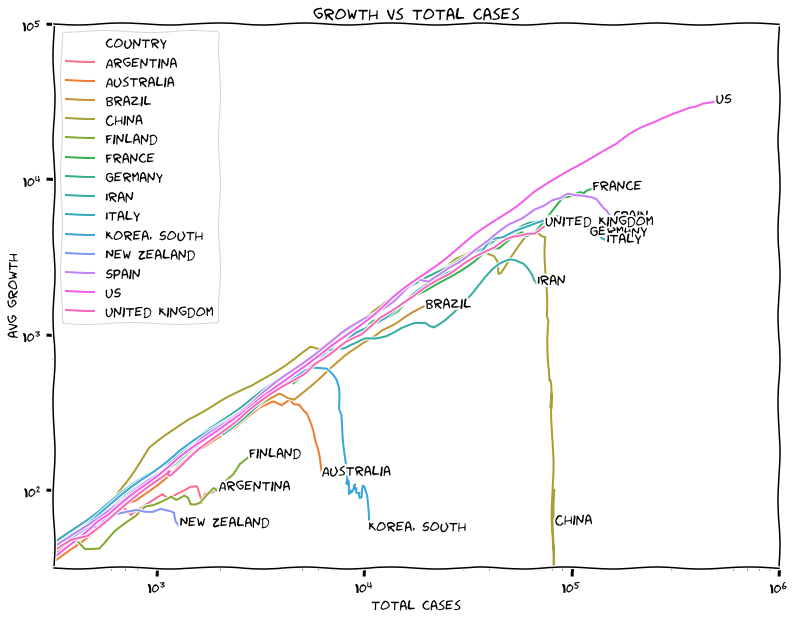

In [43]:
logPlot(
    "growth vs total cases",
    "figs/gif/world.png",
    w,
    "country",
    "total cases",
    "avg growth",
    False,
    [10 ** 2.5, 10 ** 6],
    [10 ** 1.5, 10 ** 5],
)

In [70]:
1

'01'

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


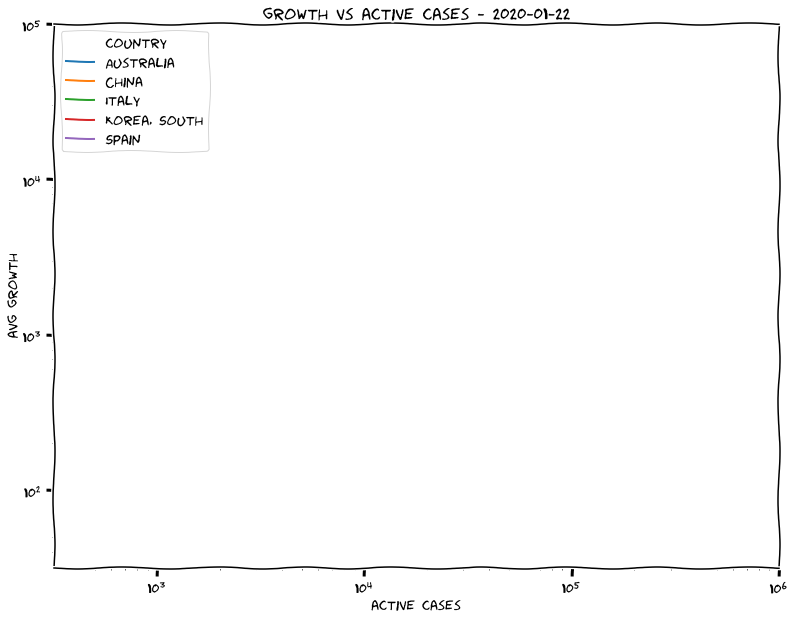

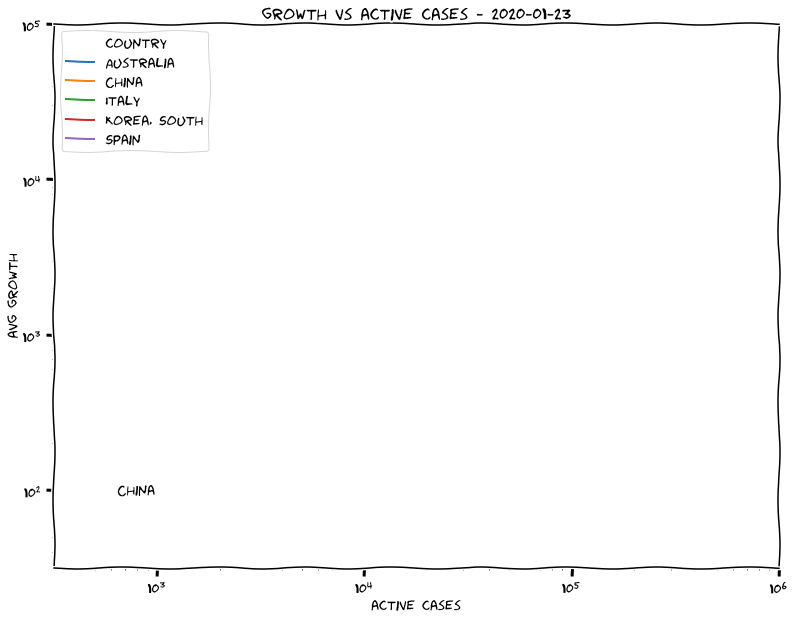

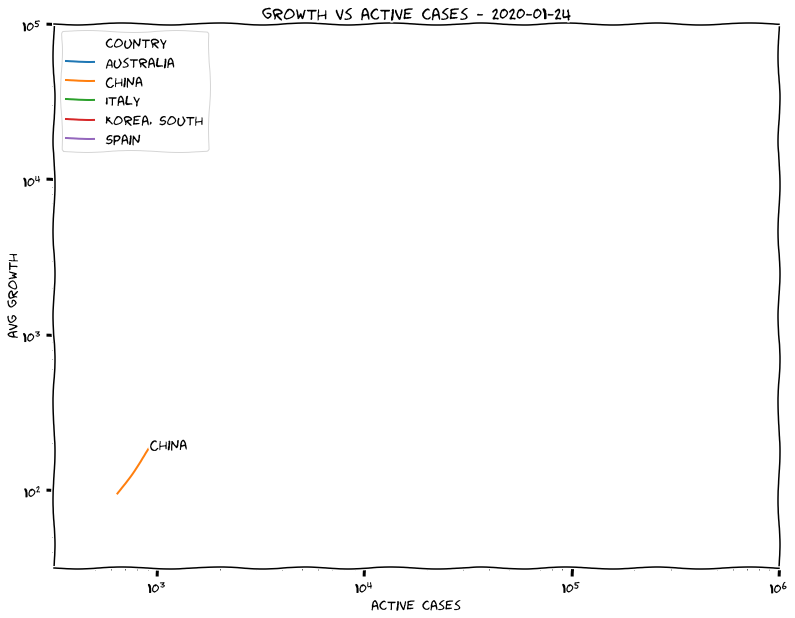

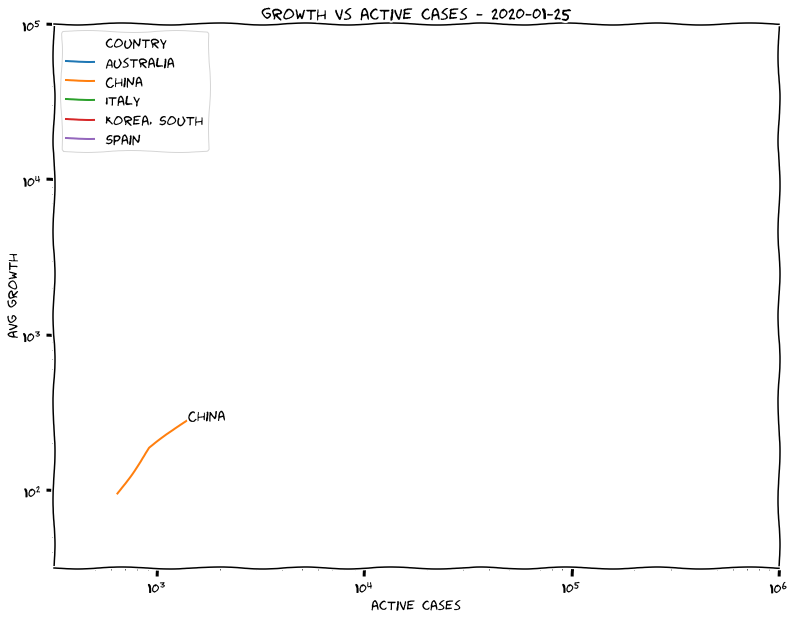

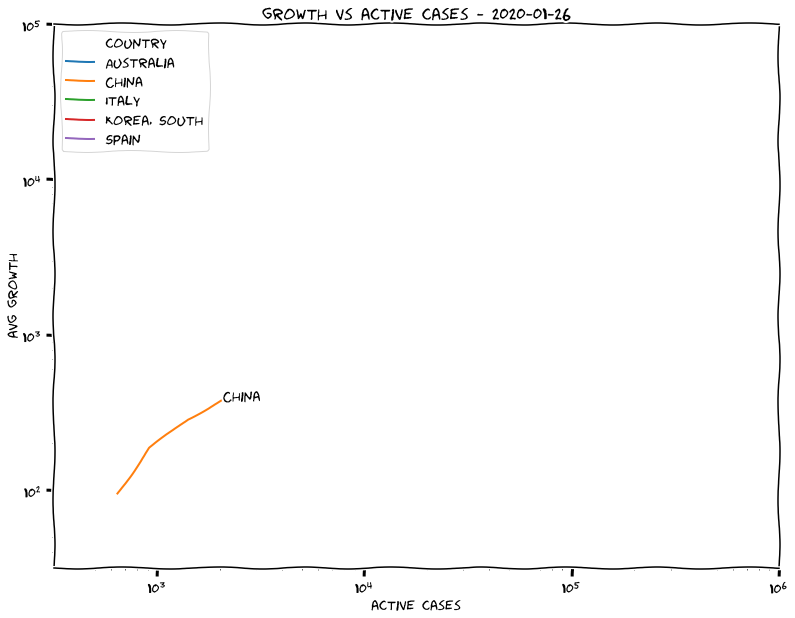

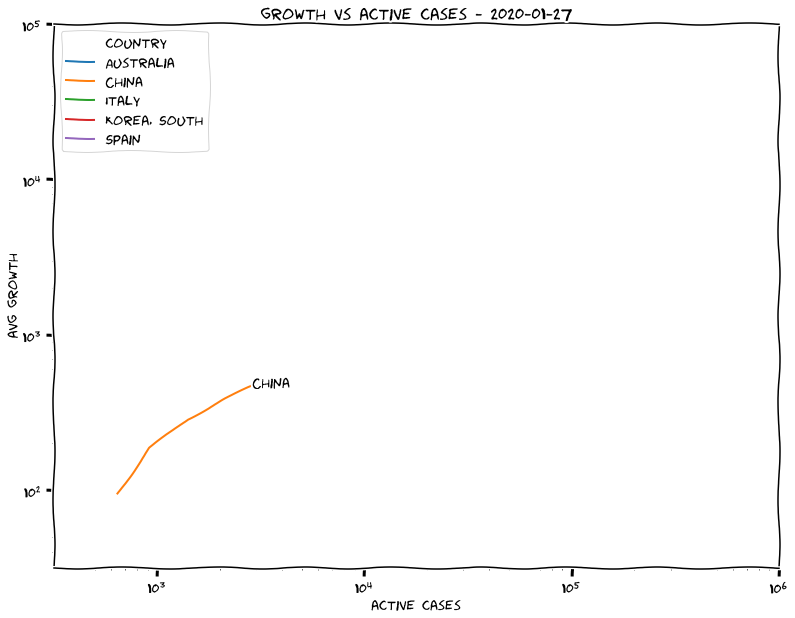

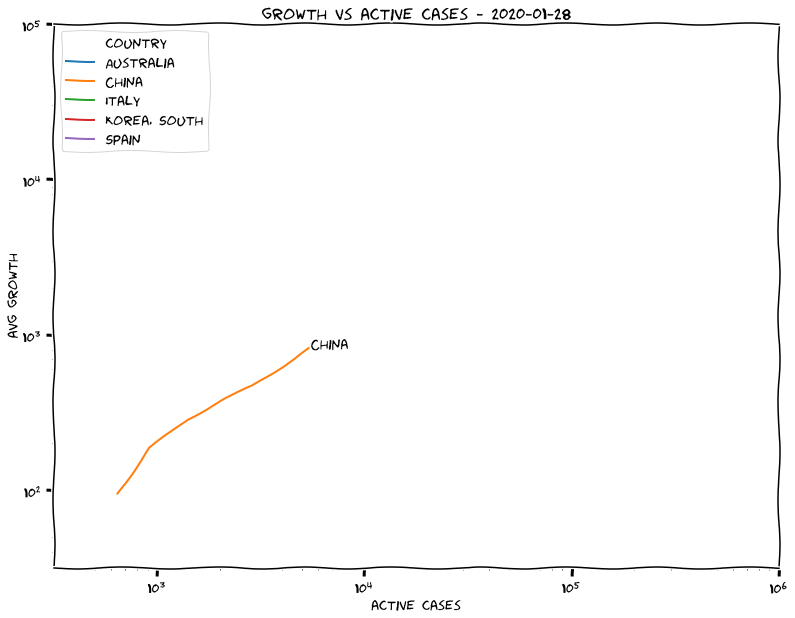

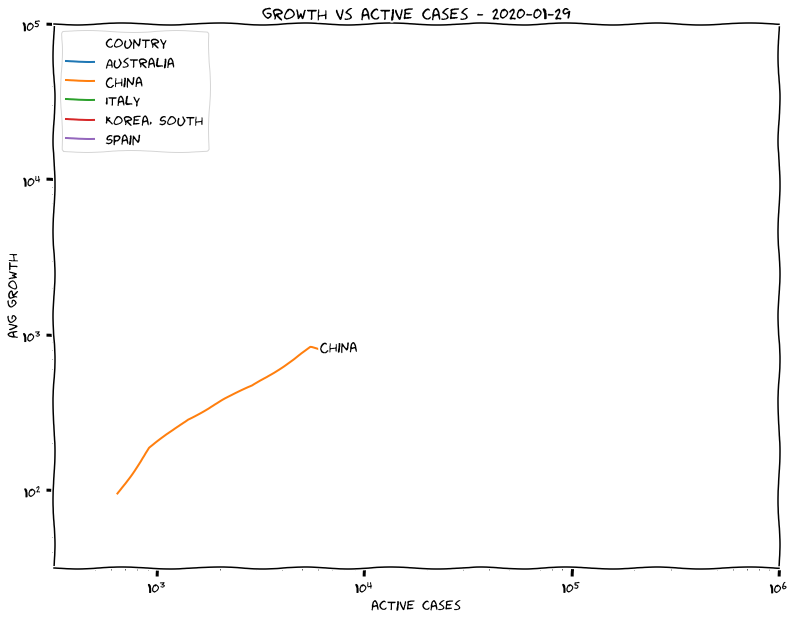

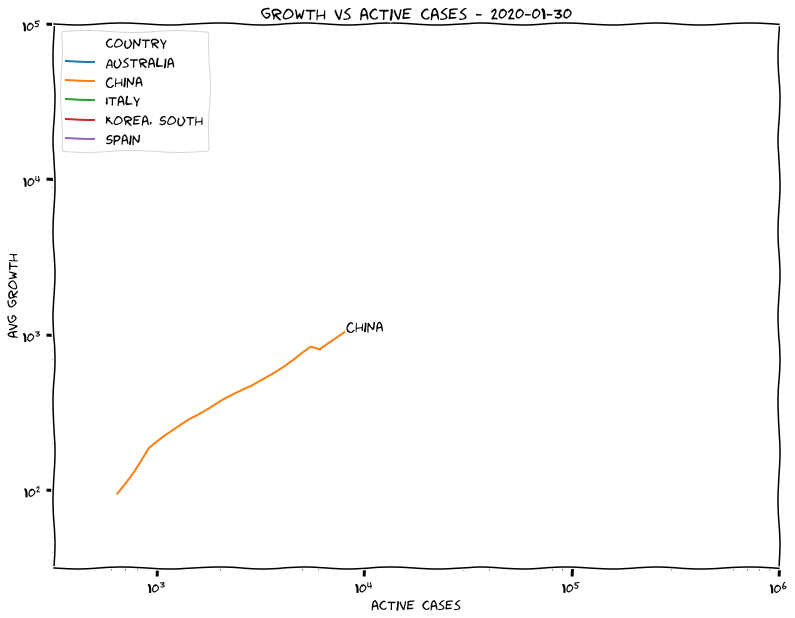

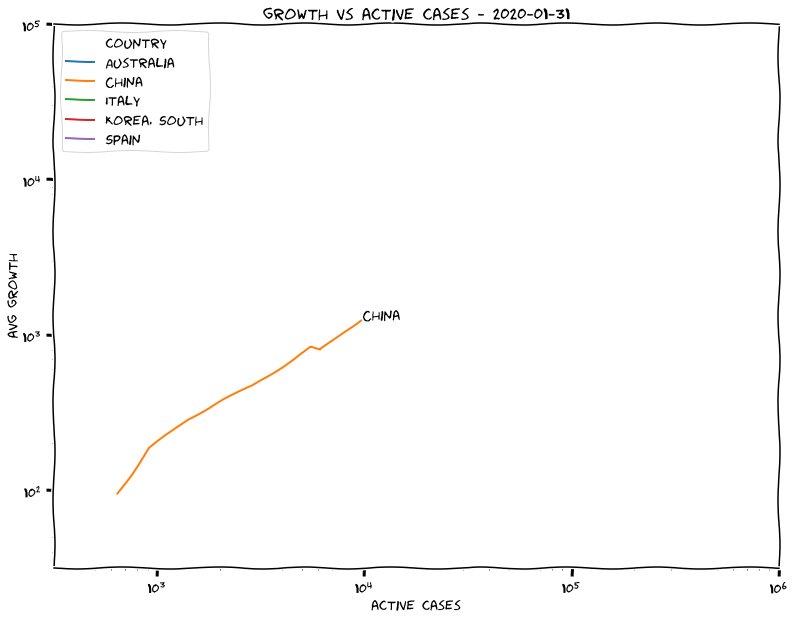

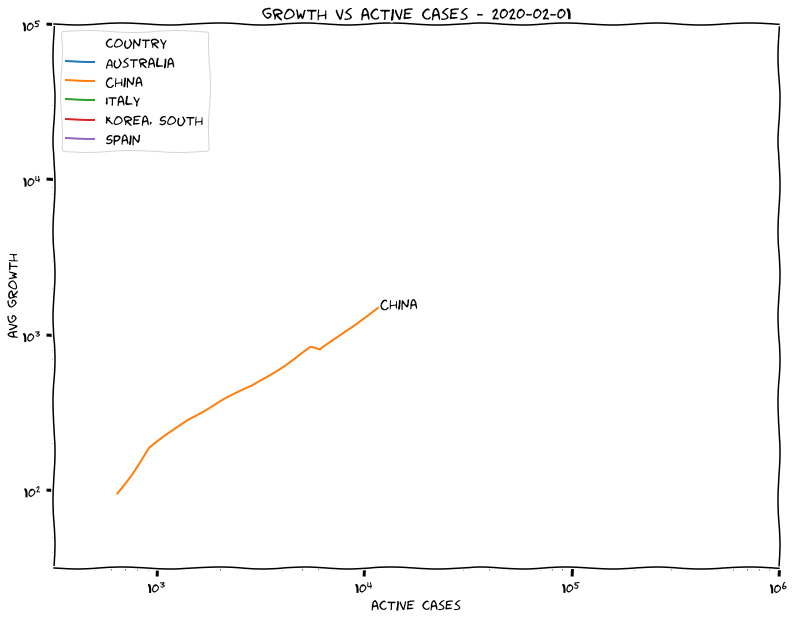

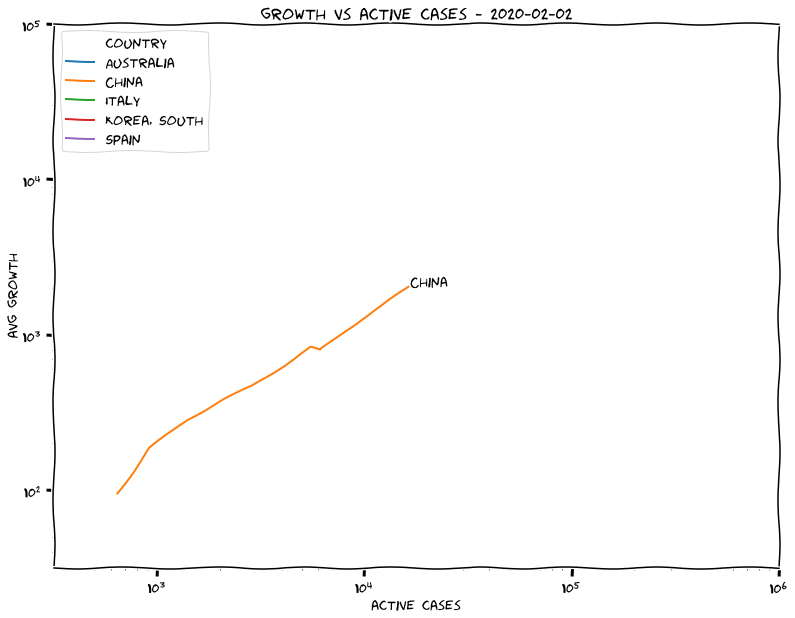

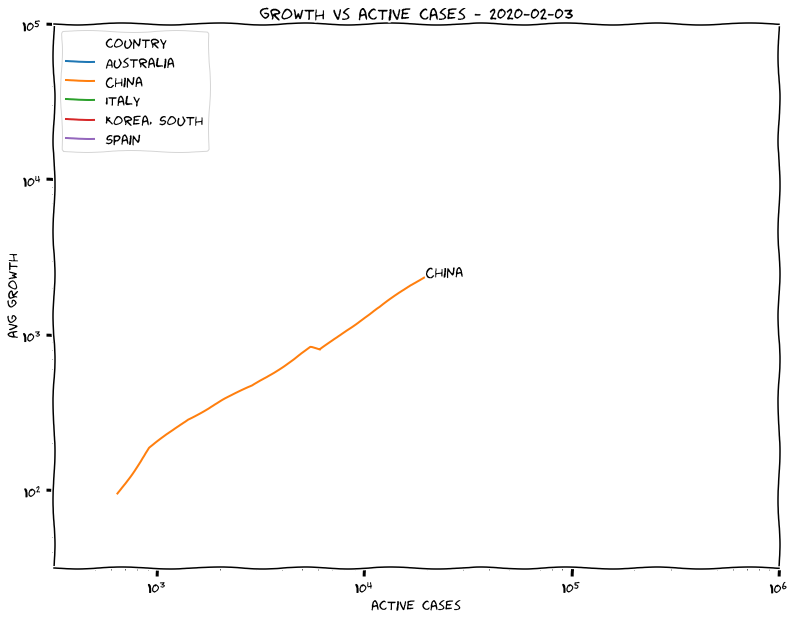

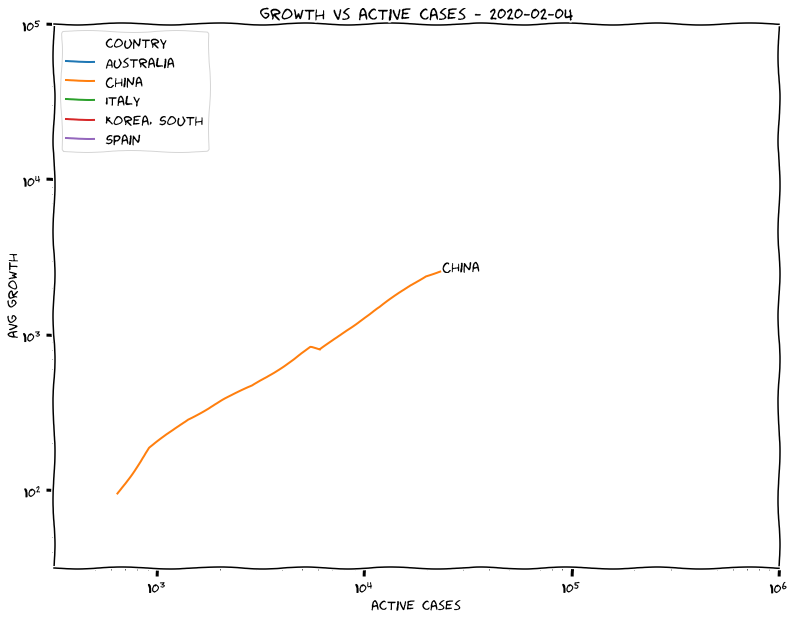

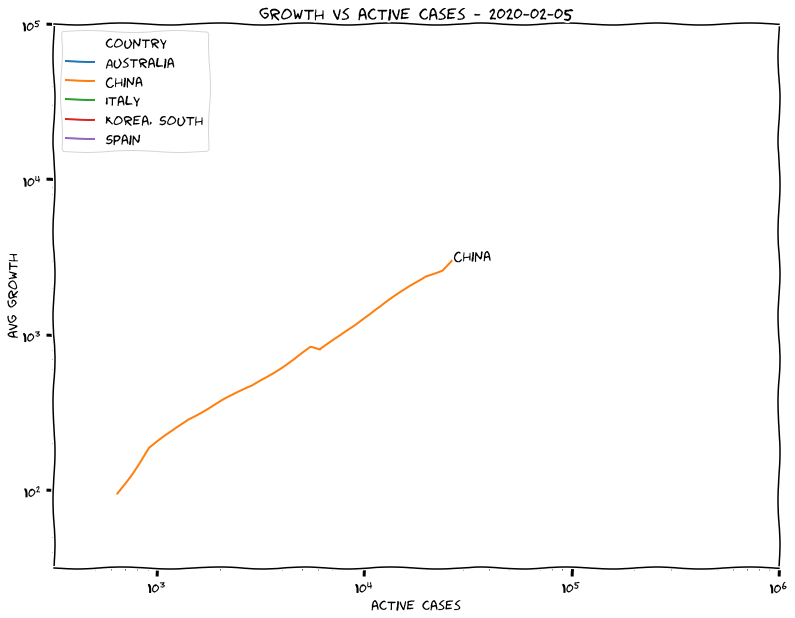

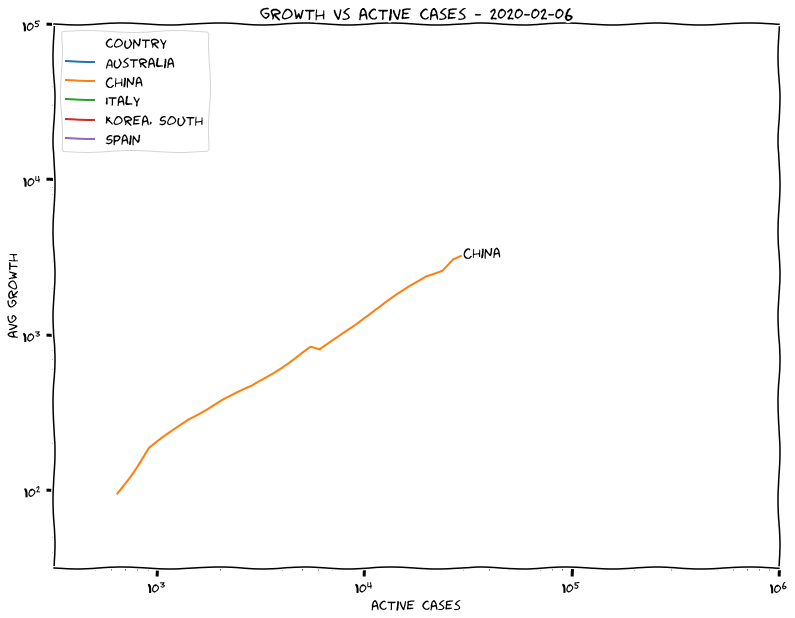

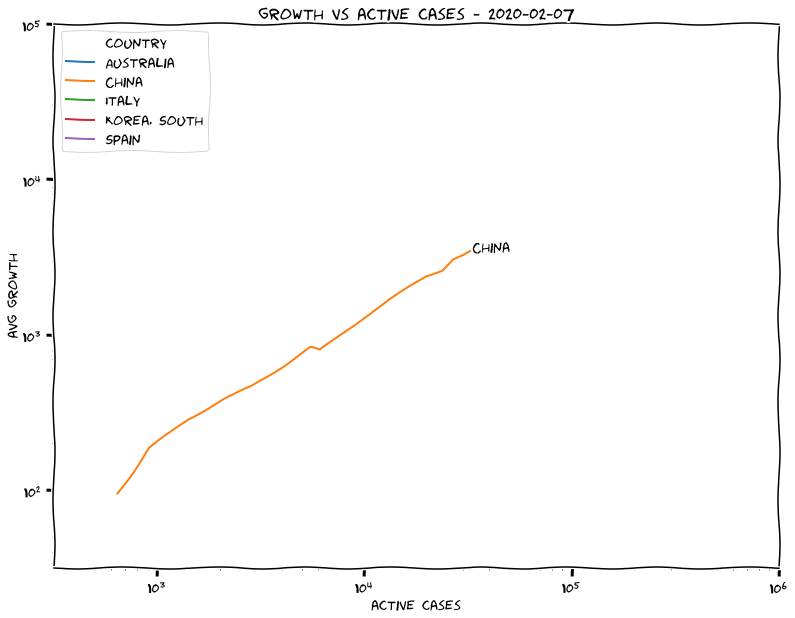

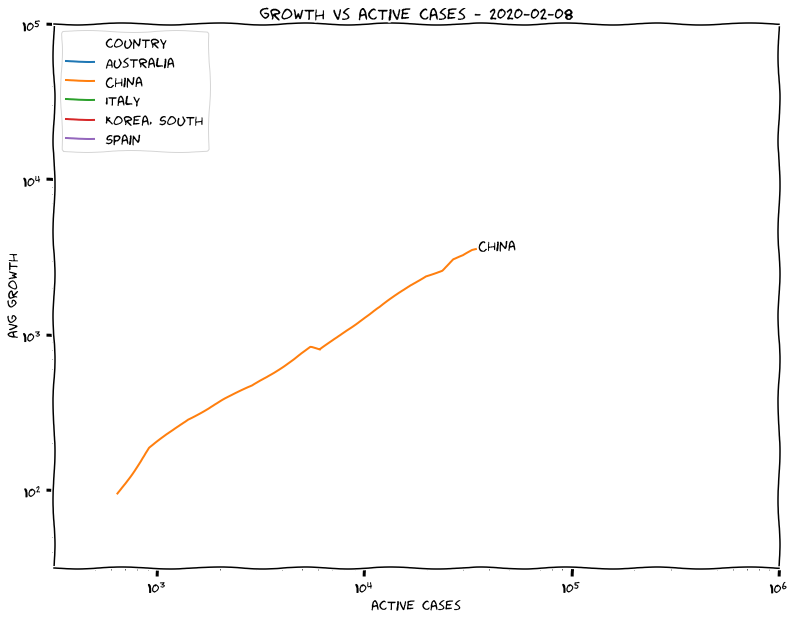

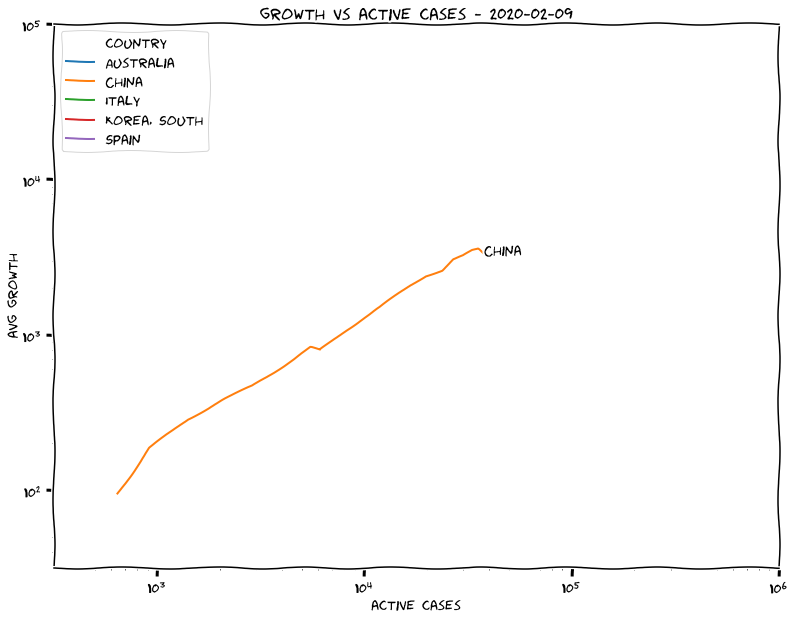

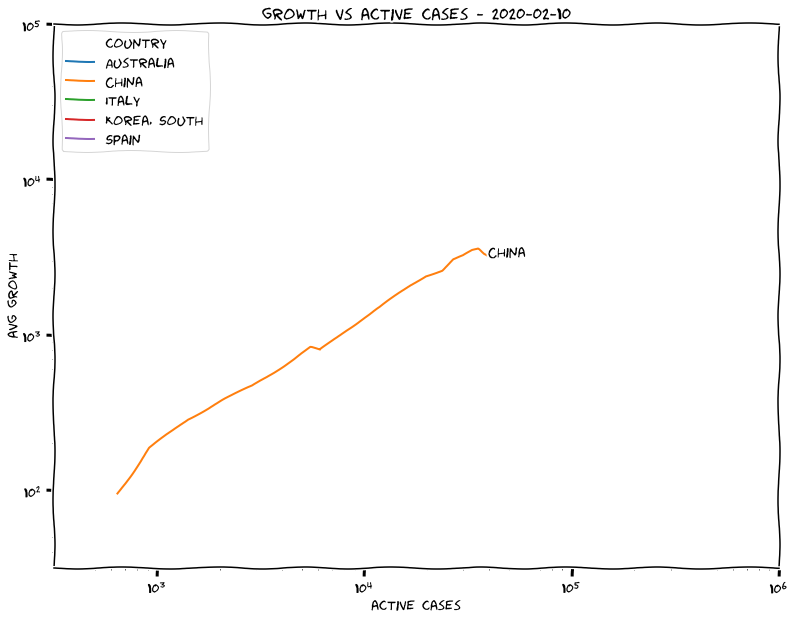

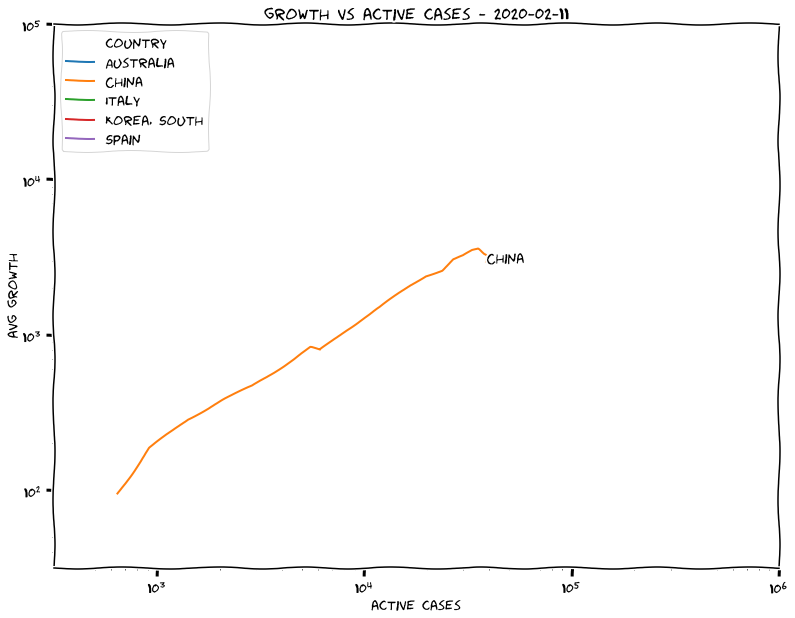

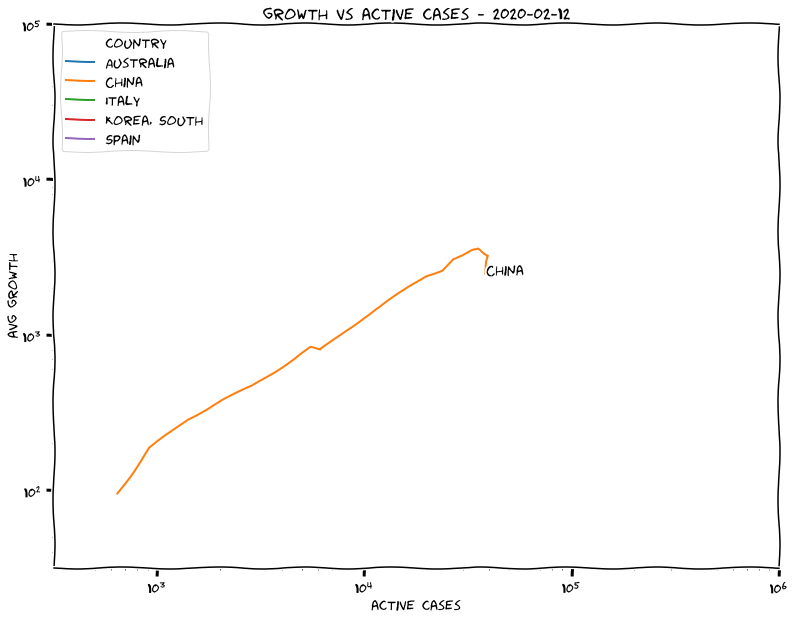

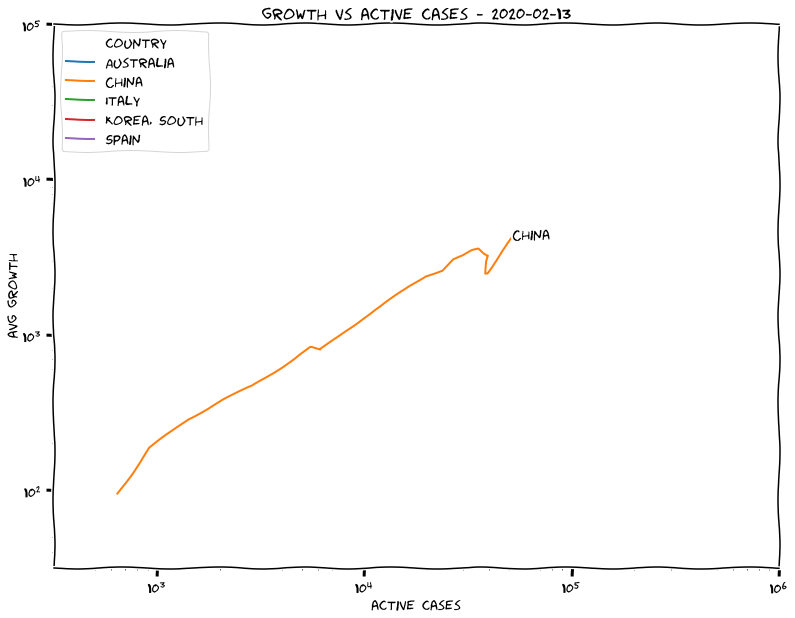

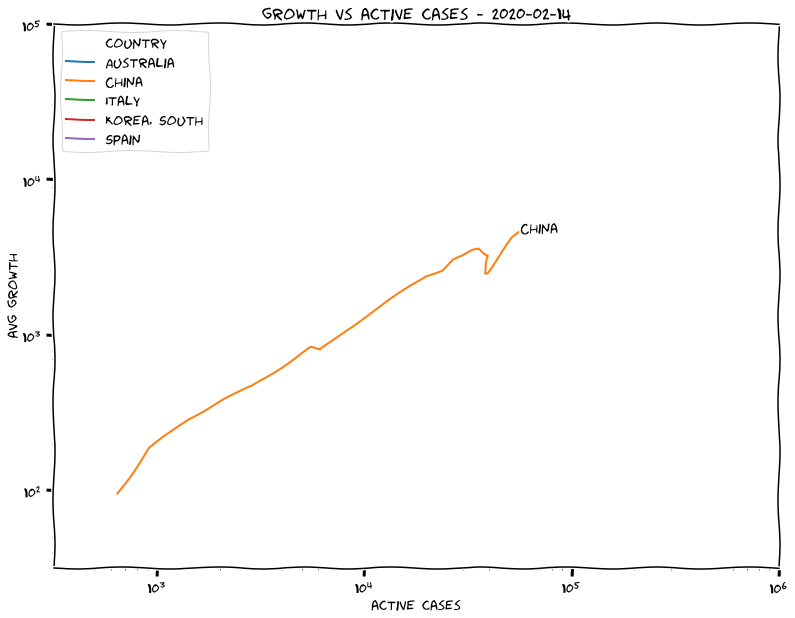

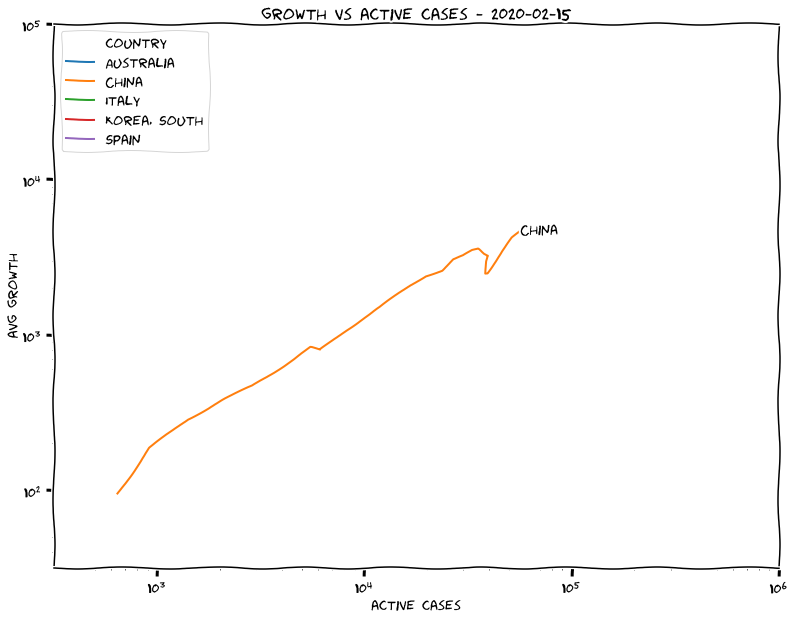

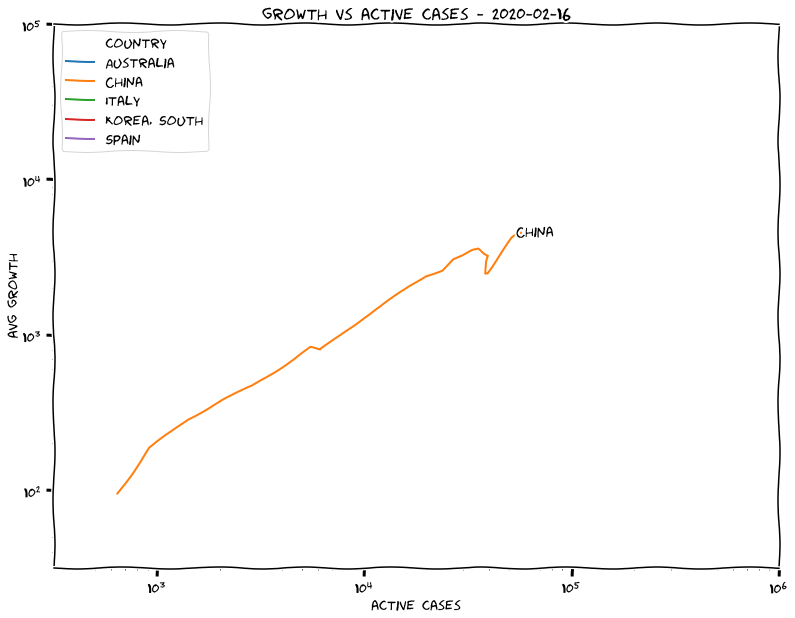

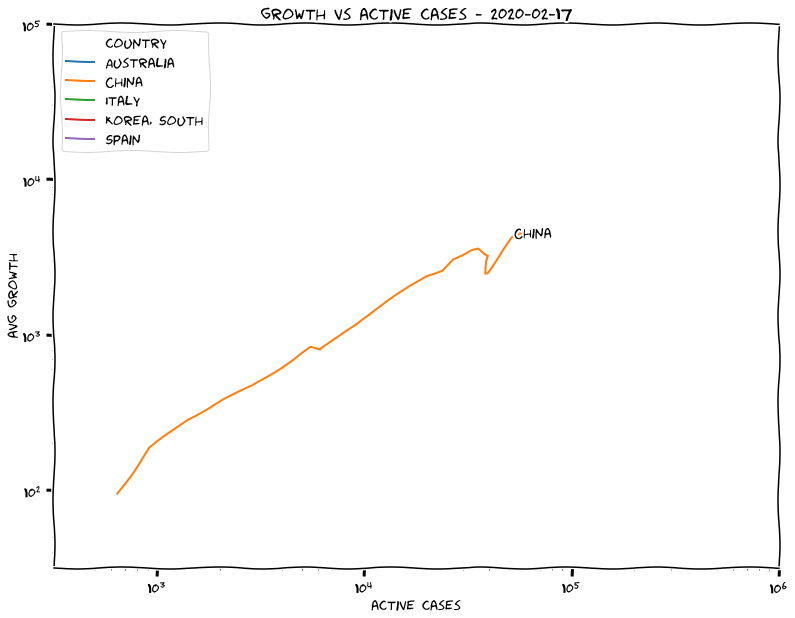

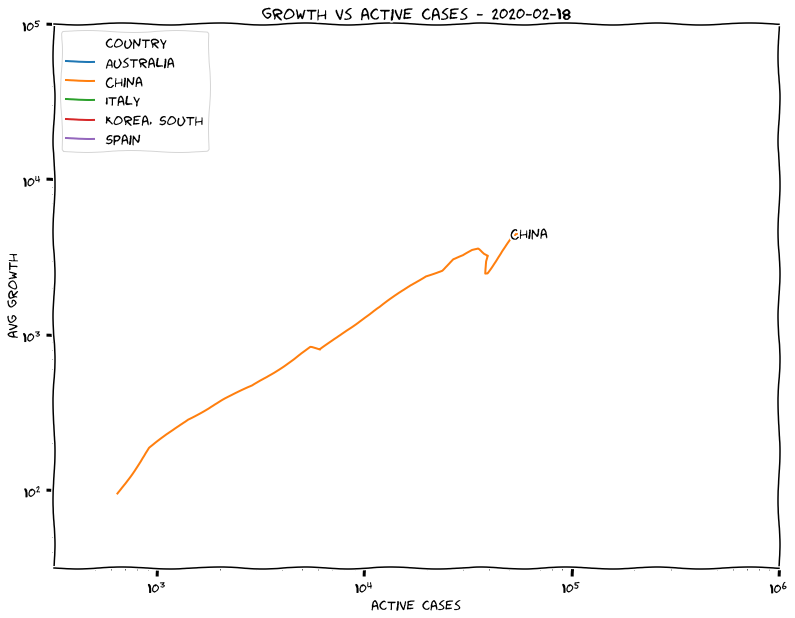

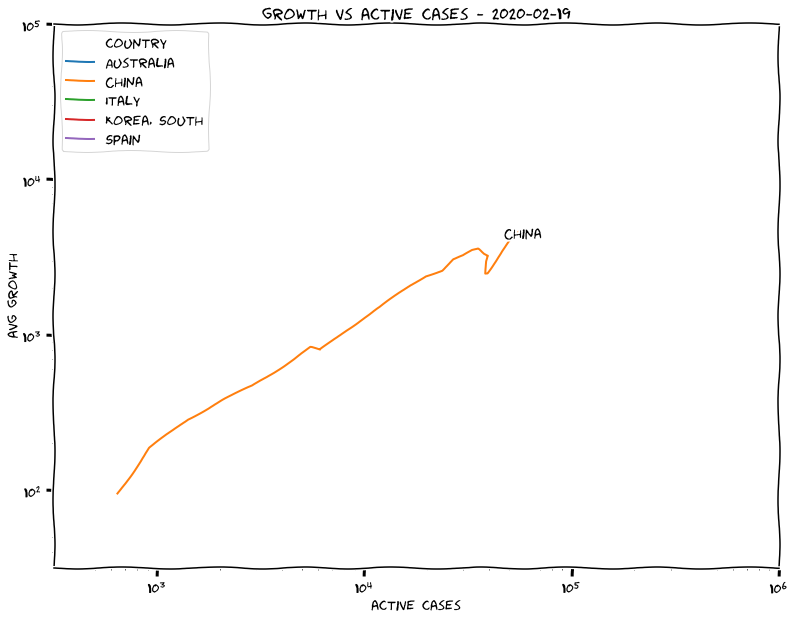

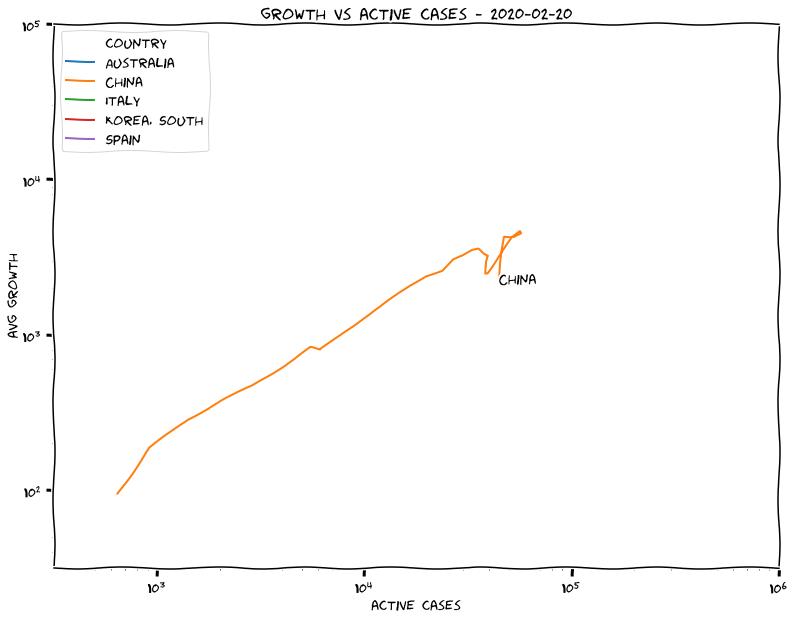

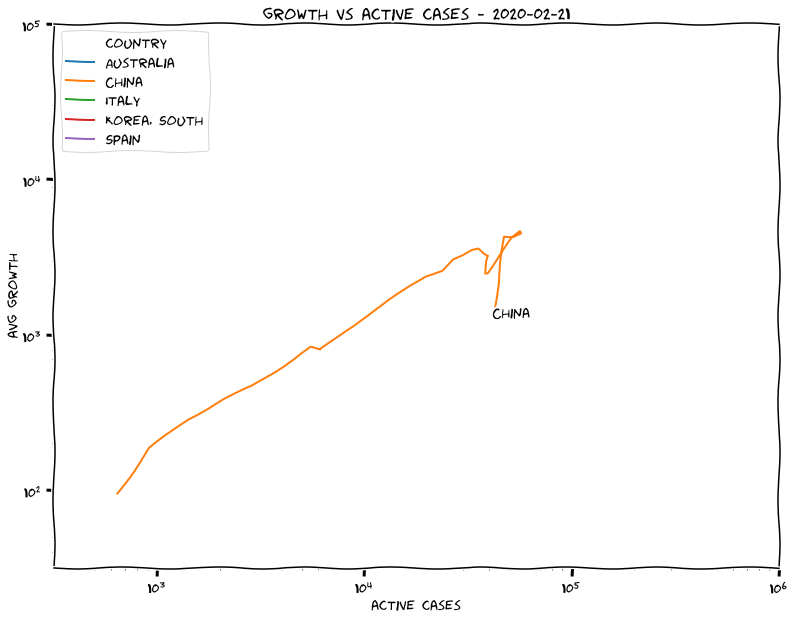

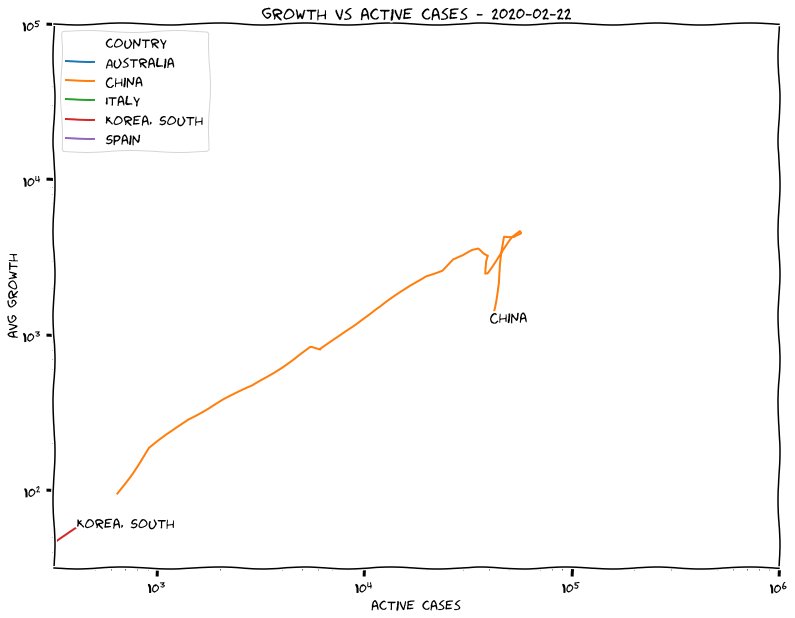

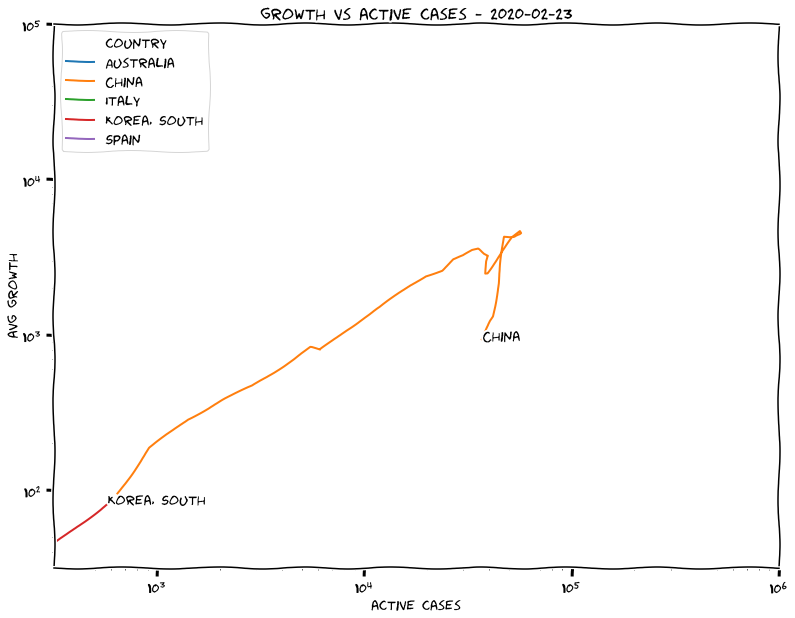

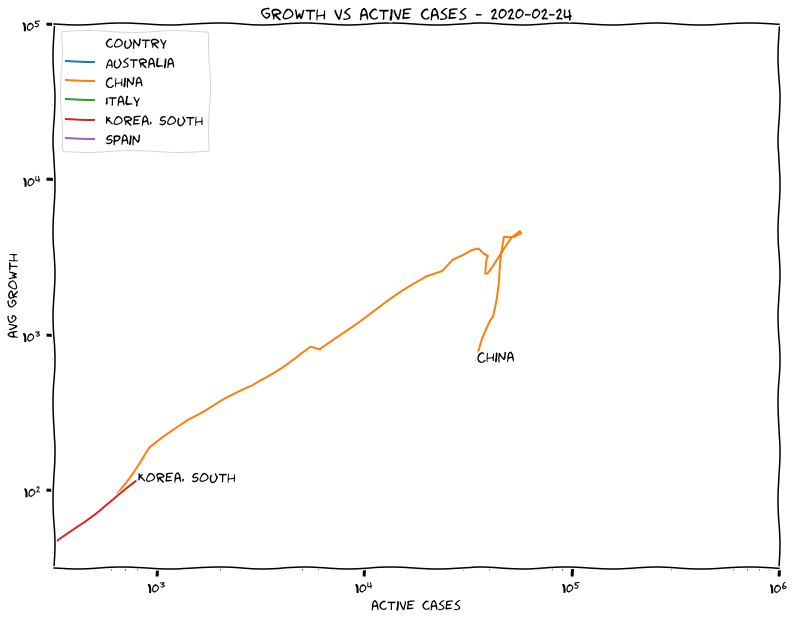

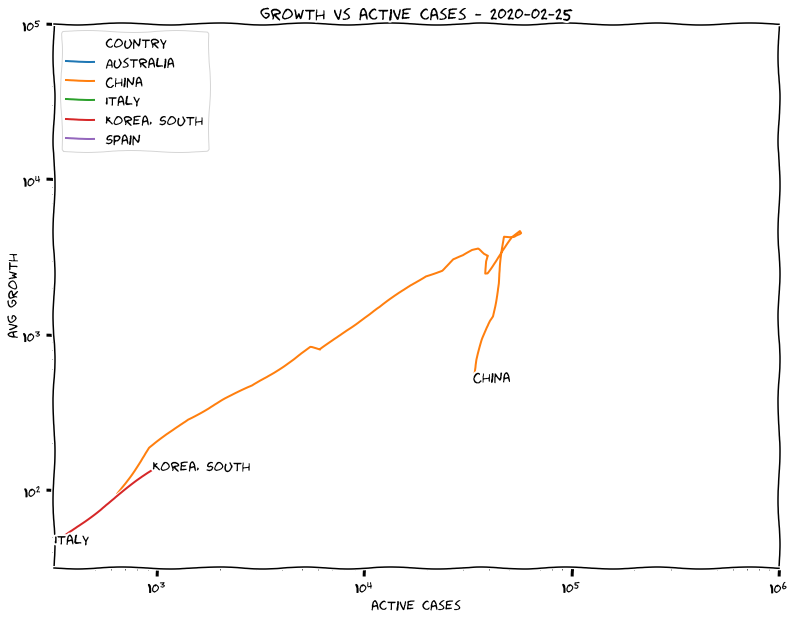

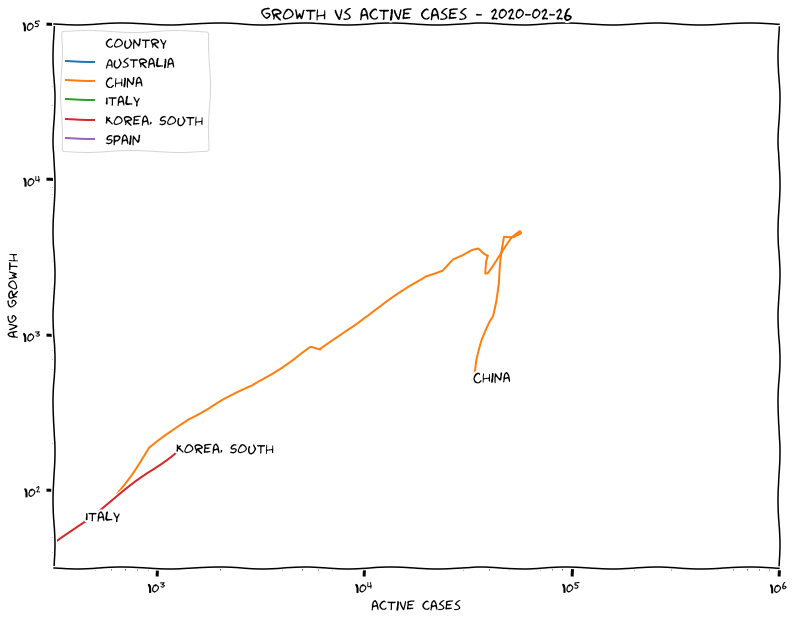

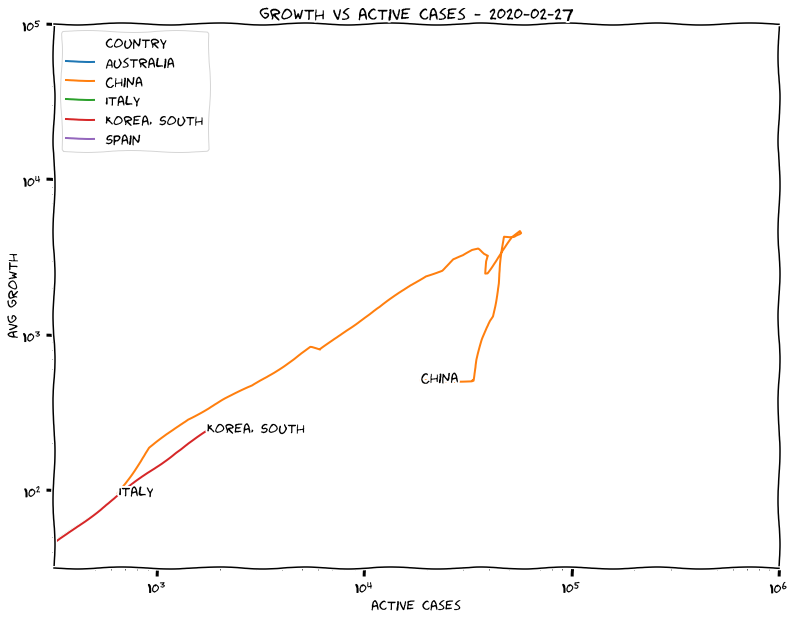

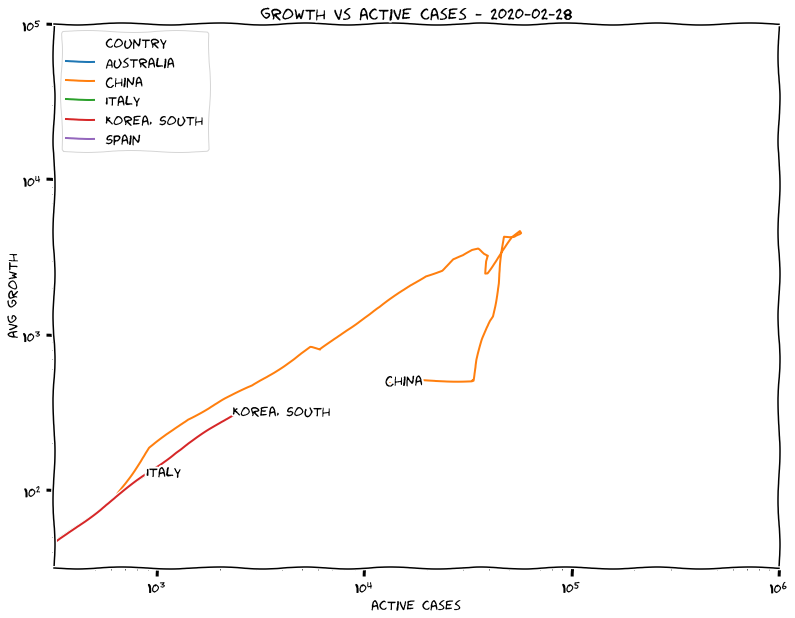

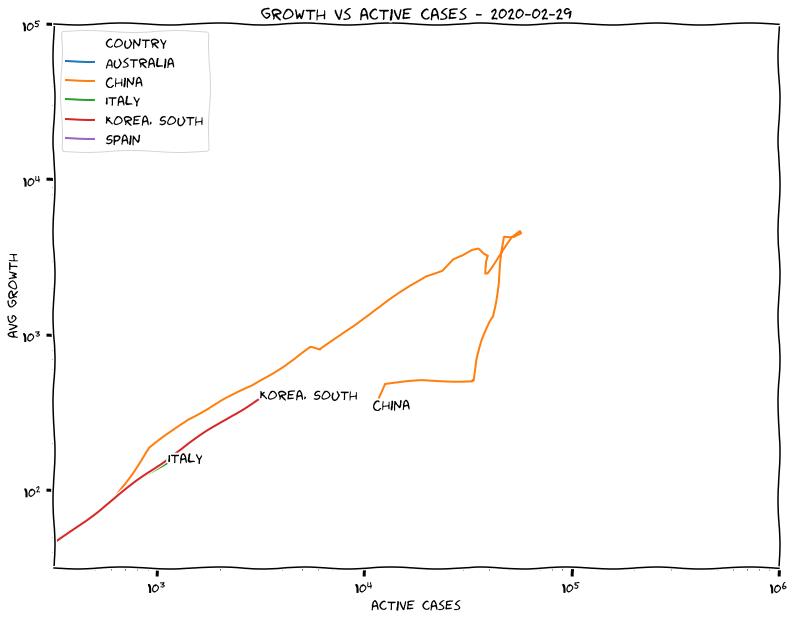

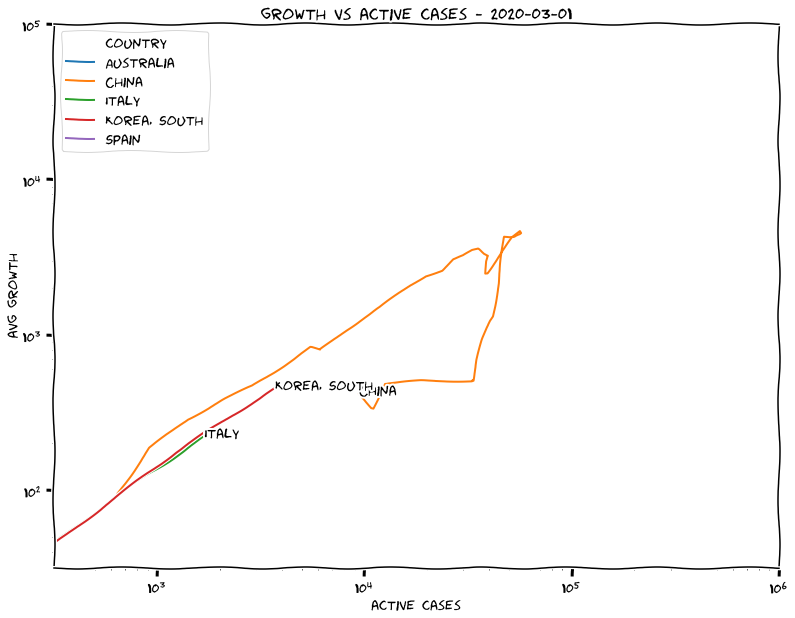

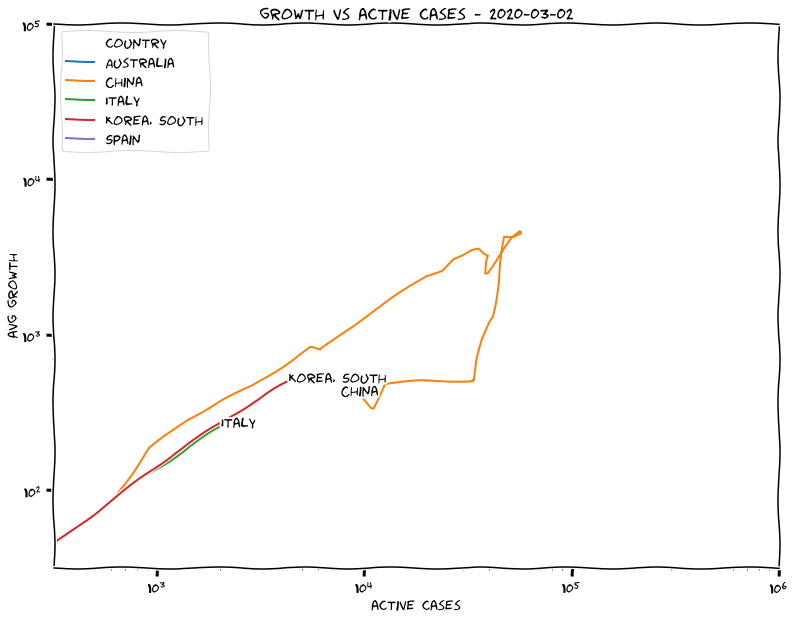

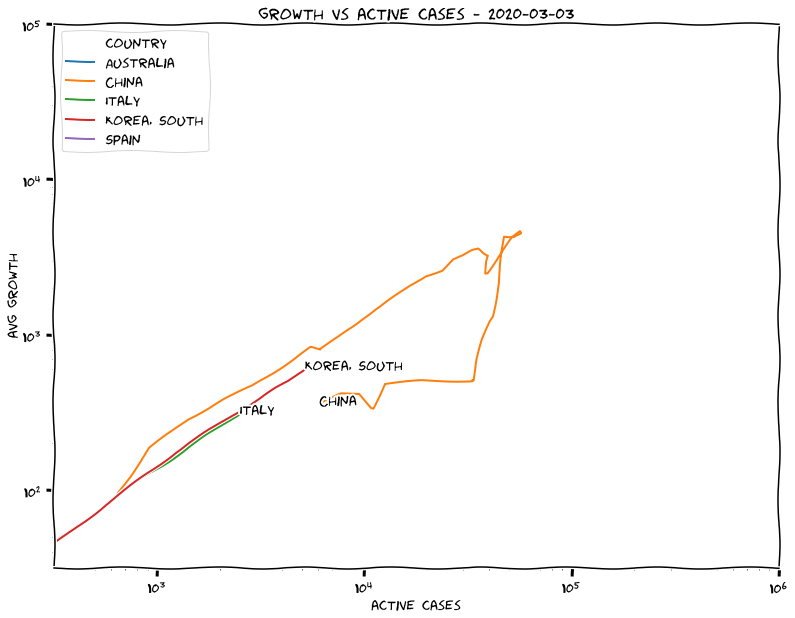

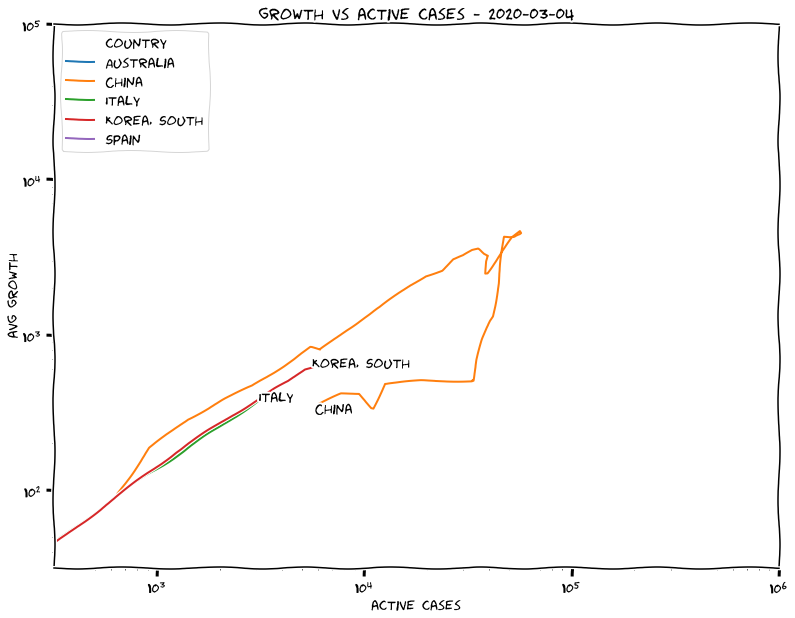

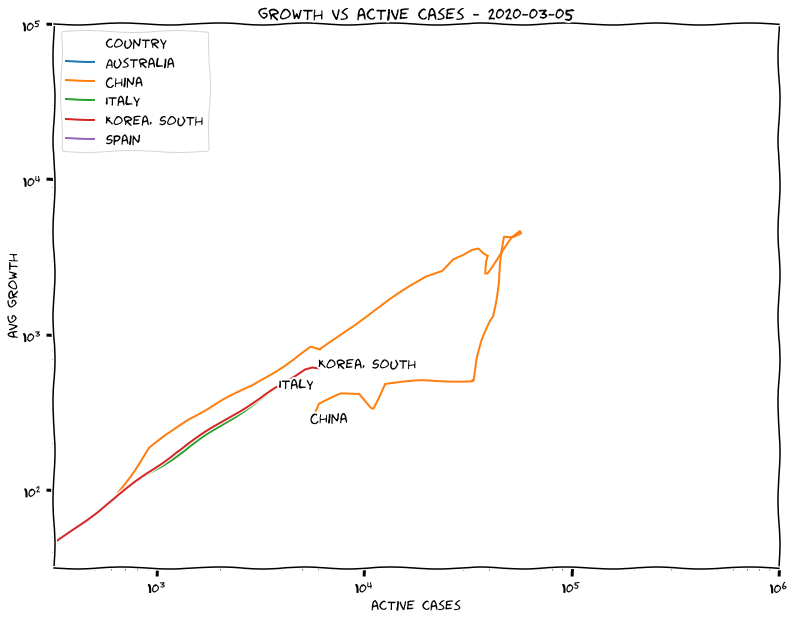

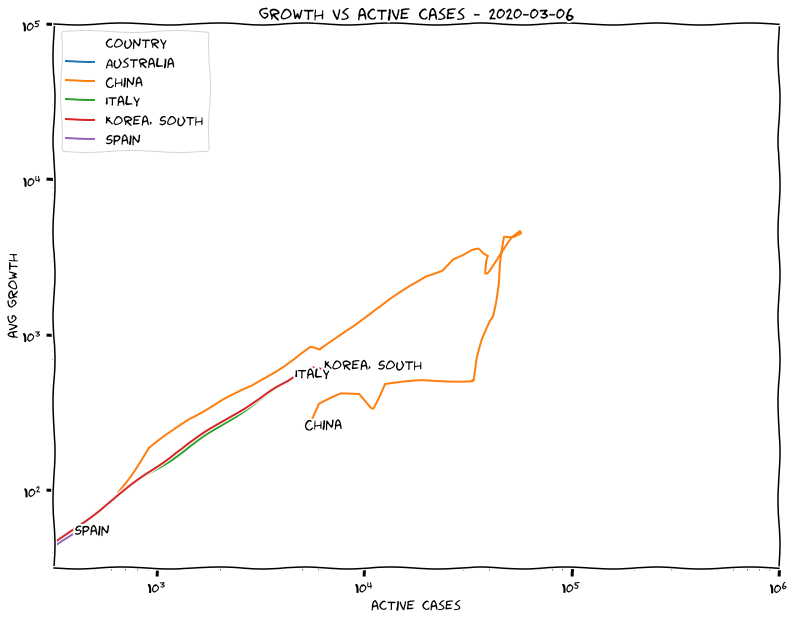

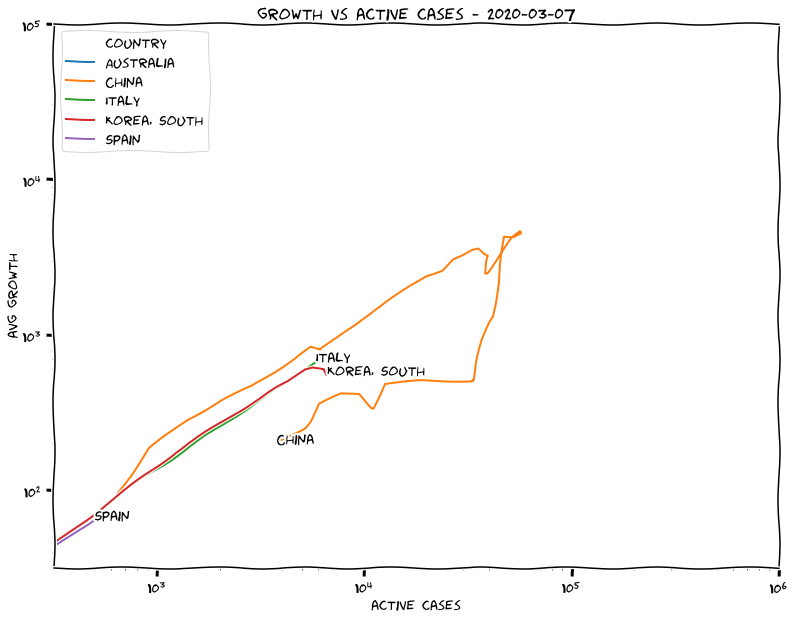

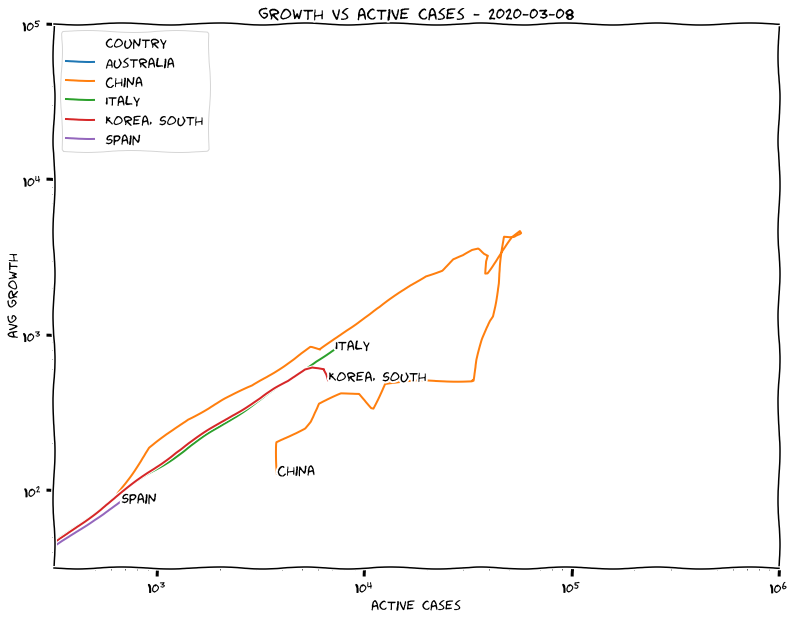

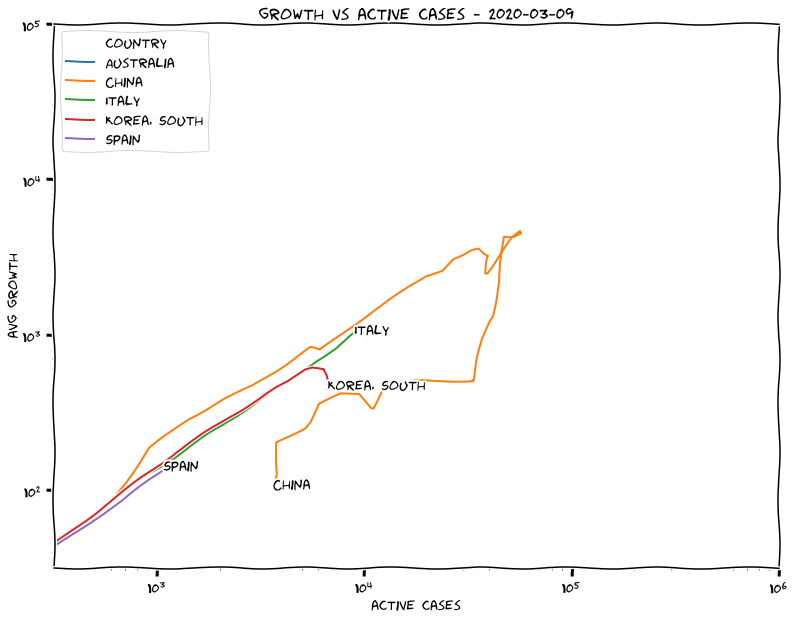

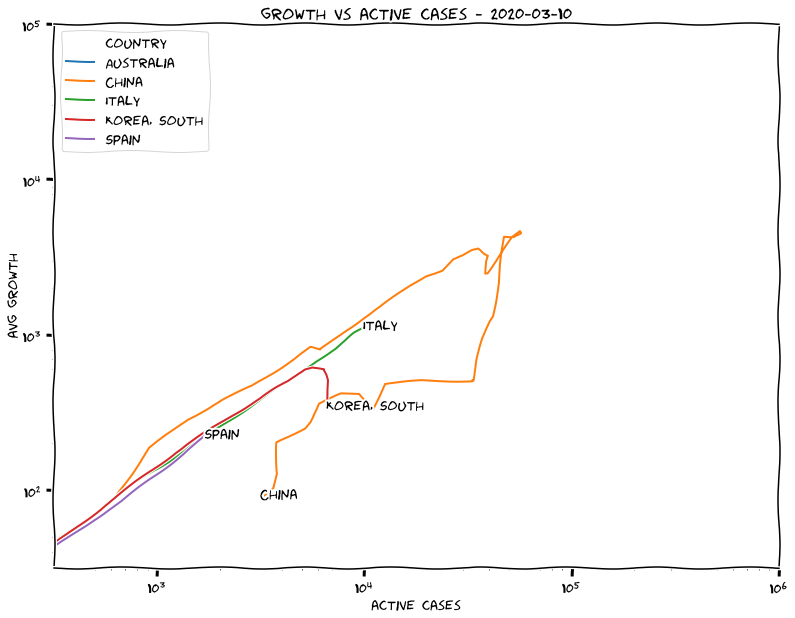

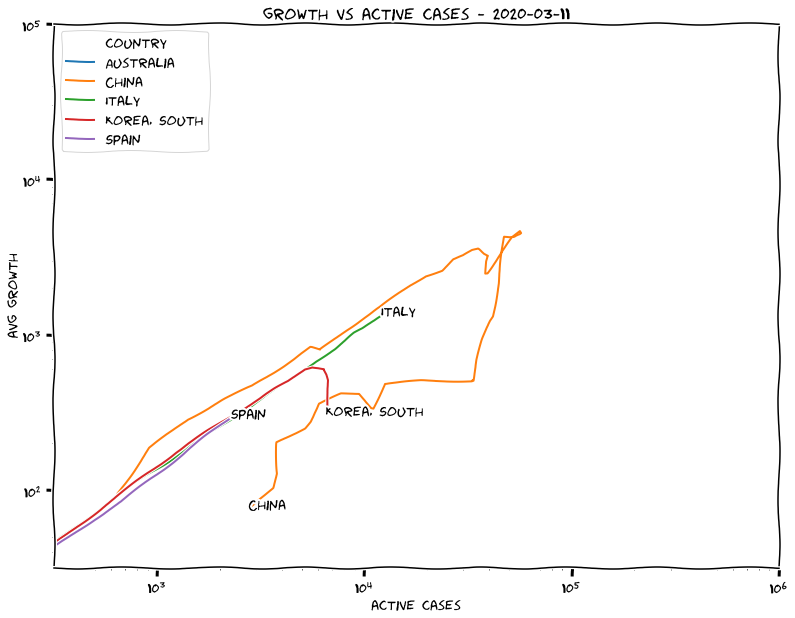

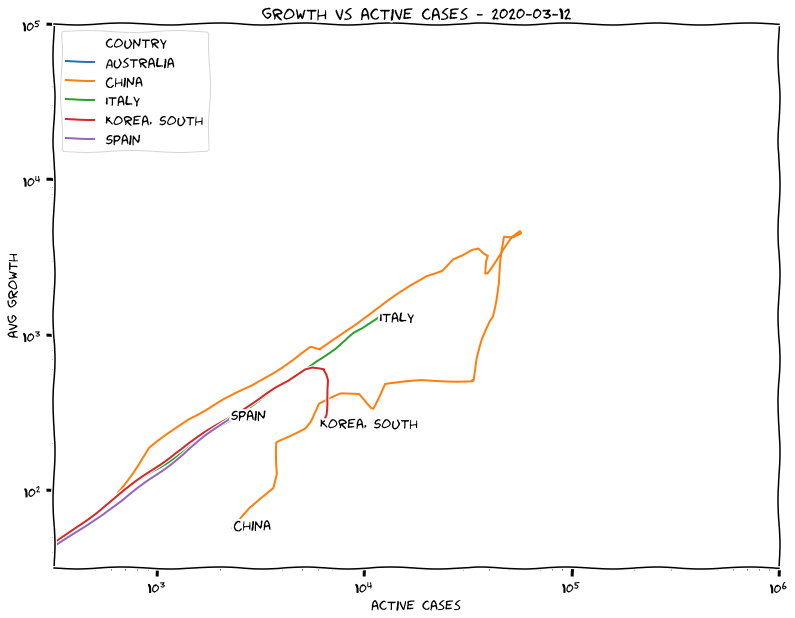

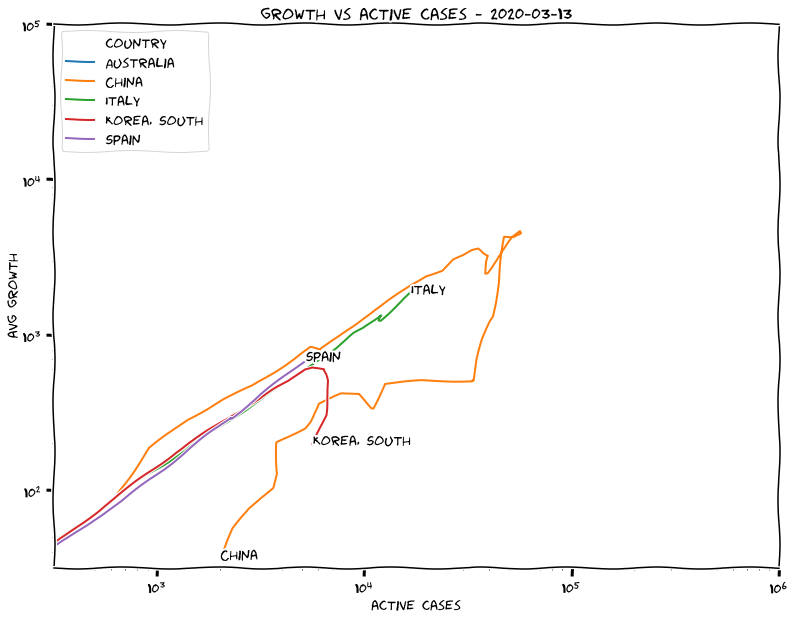

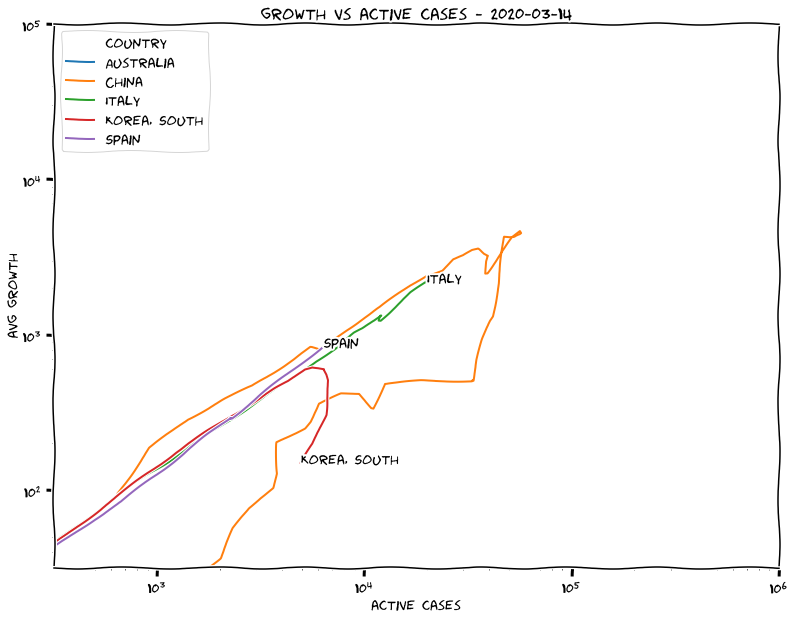

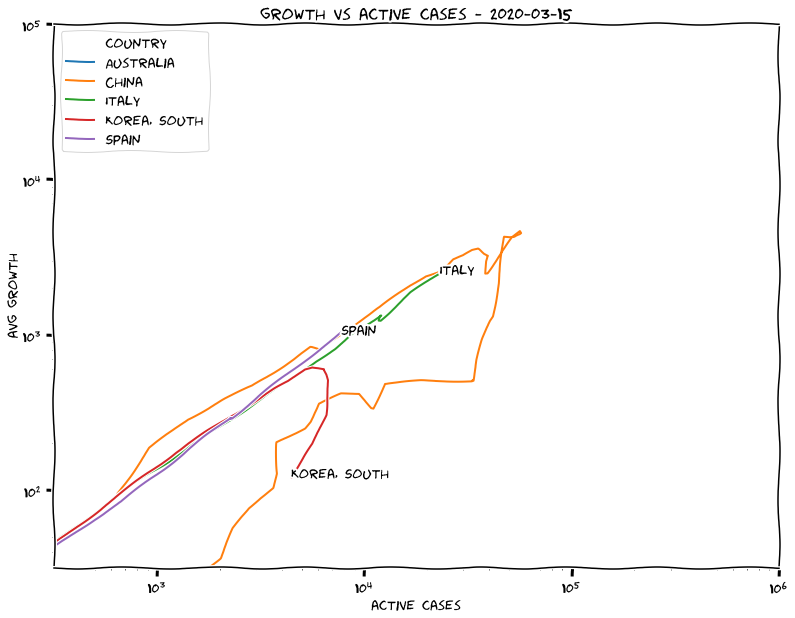

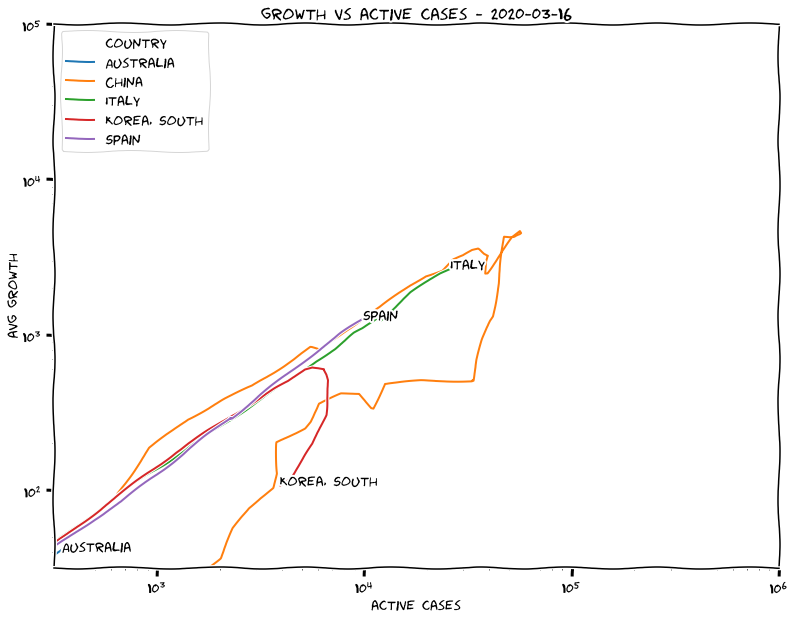

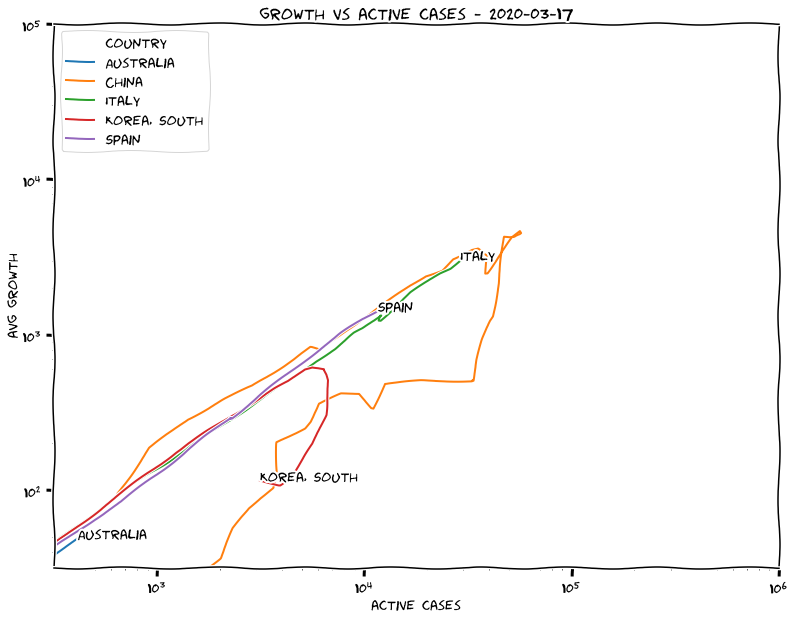

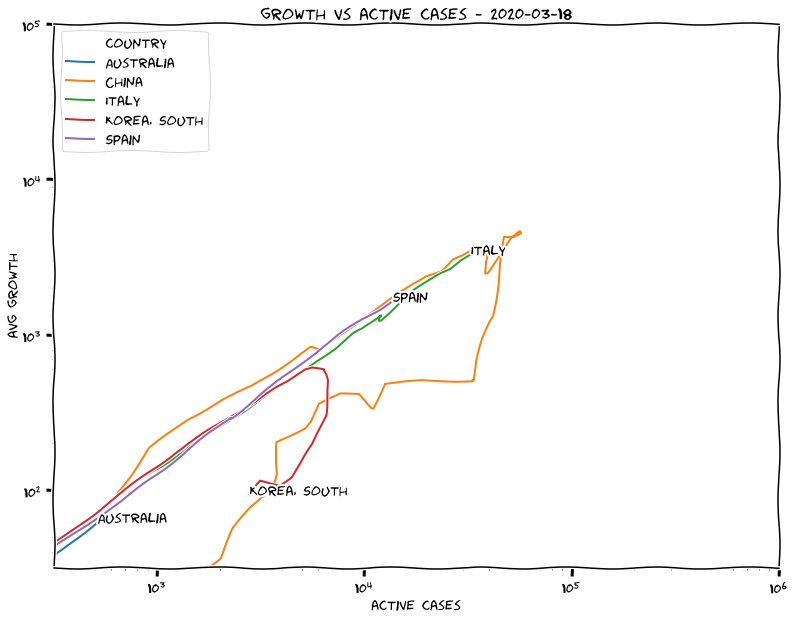

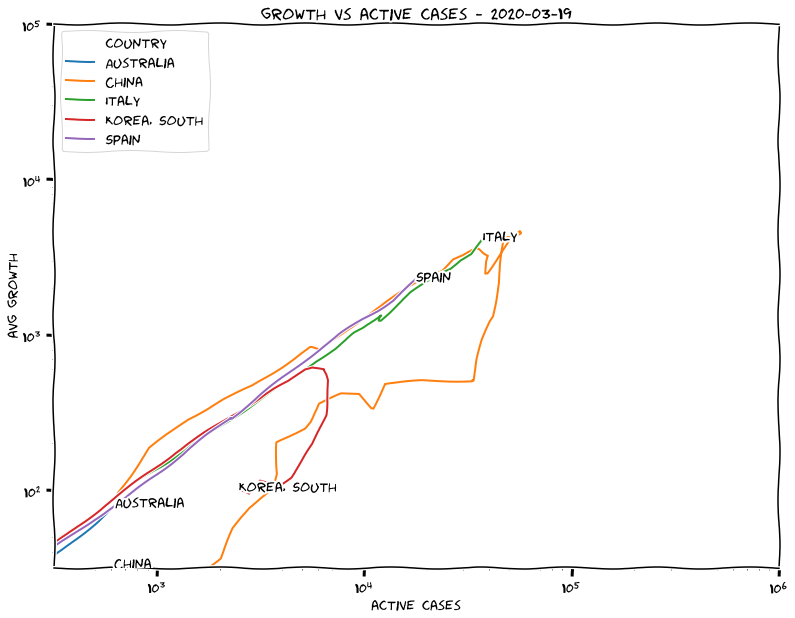

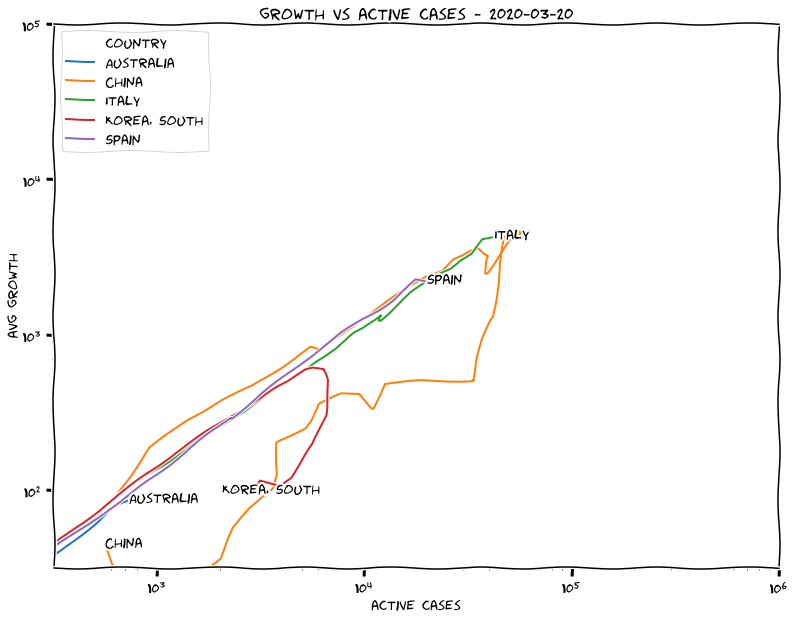

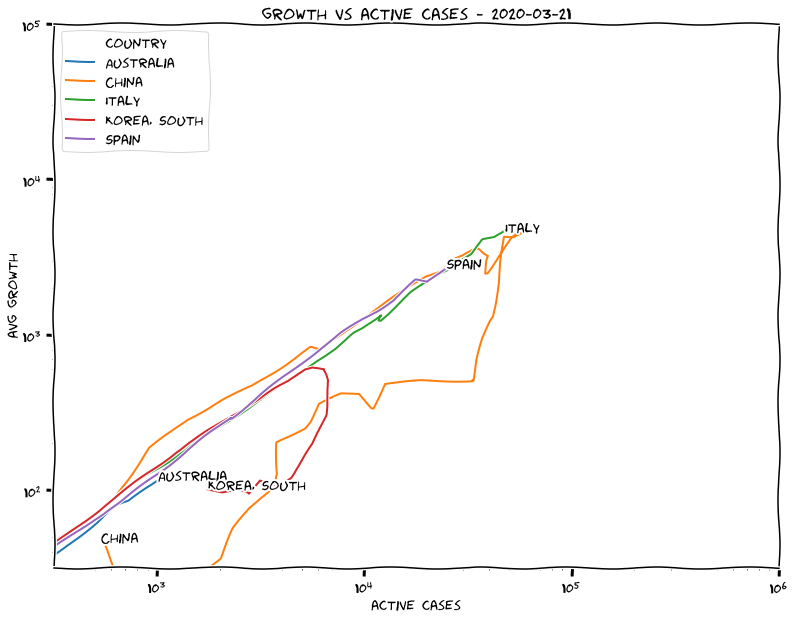

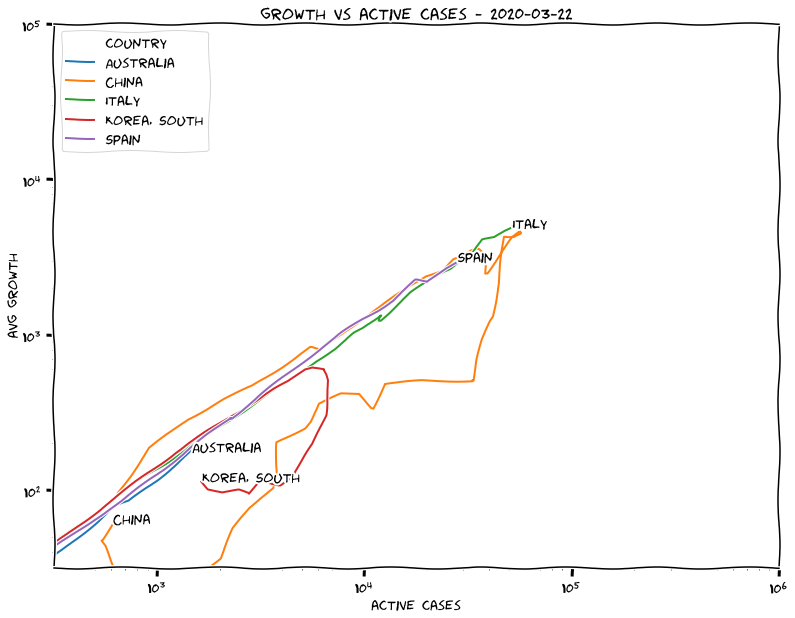

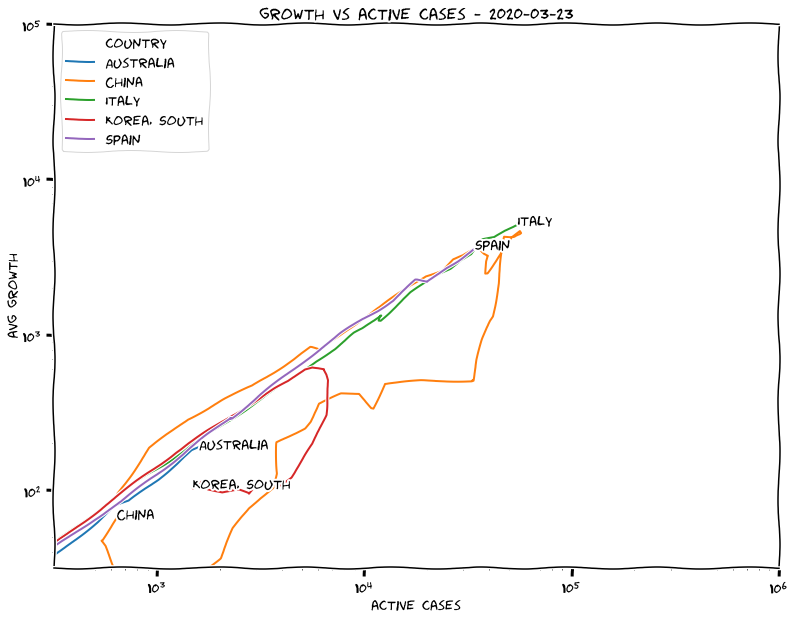

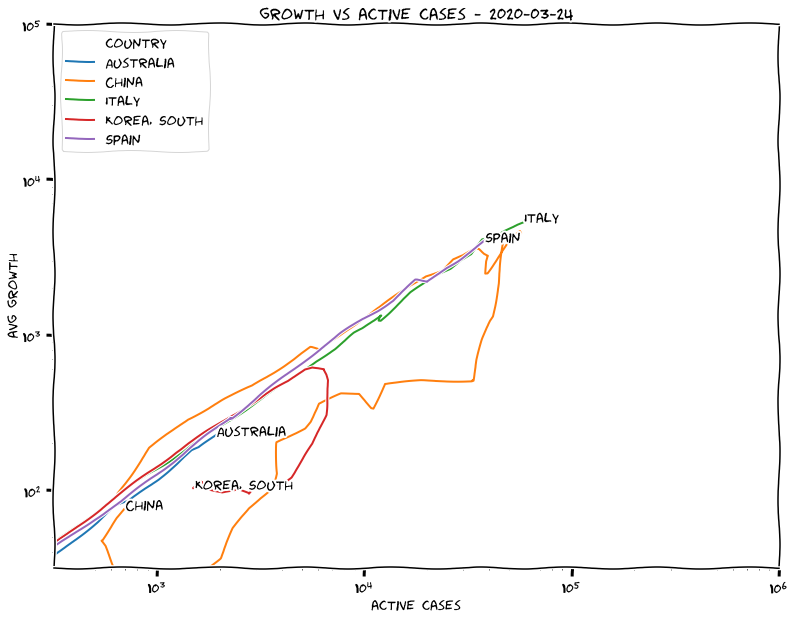

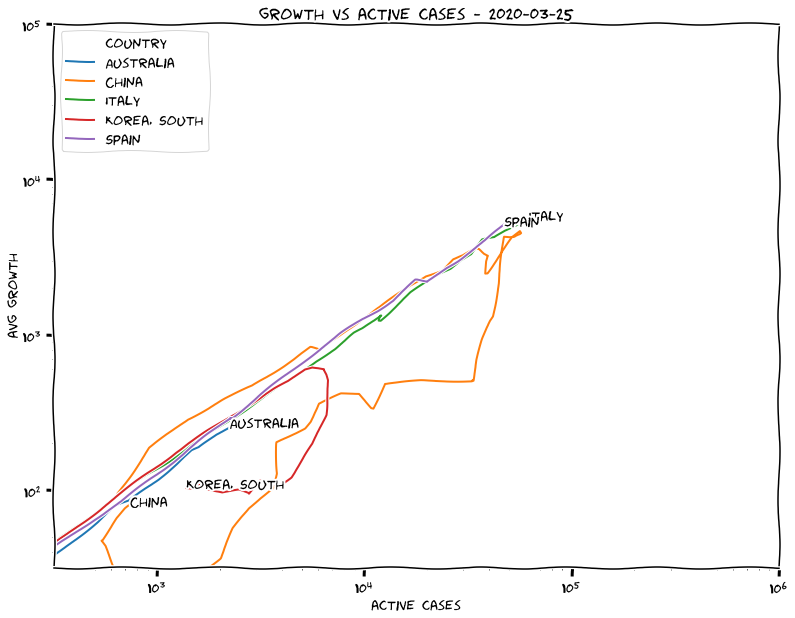

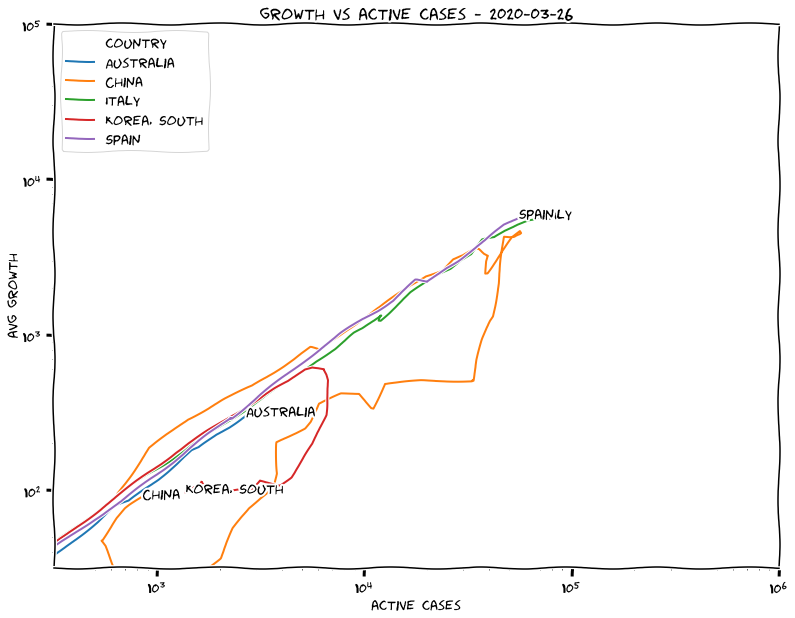

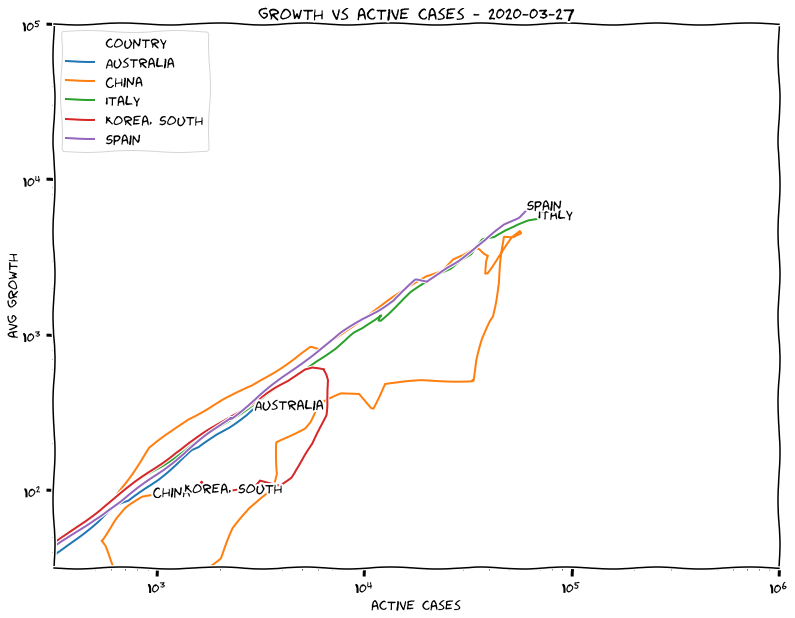

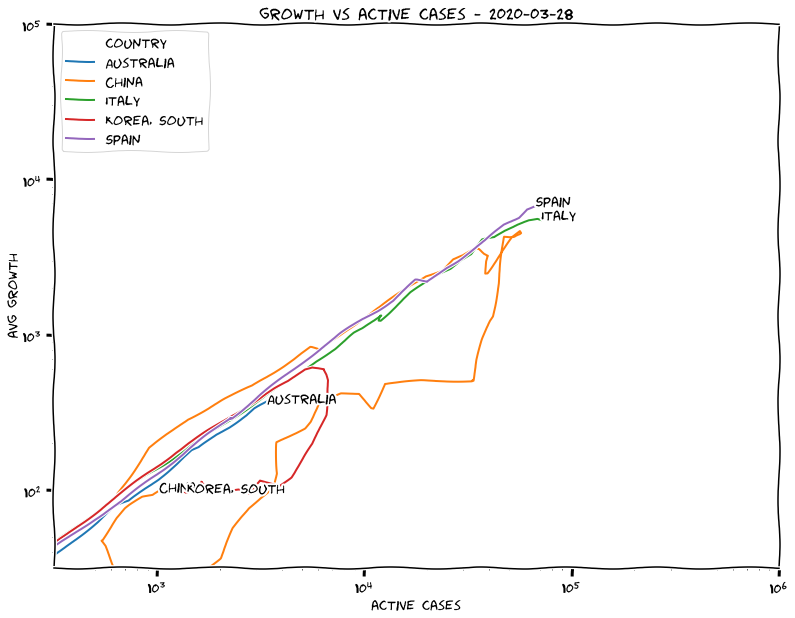

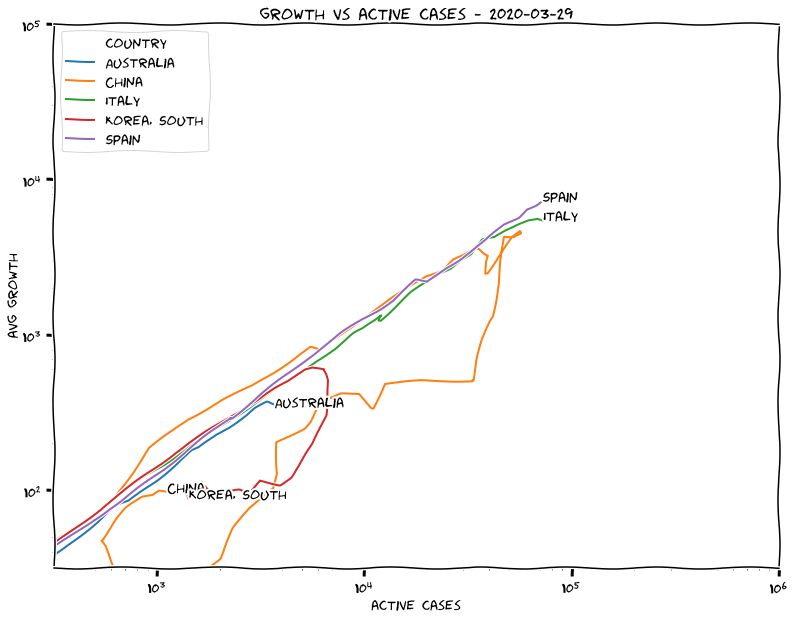

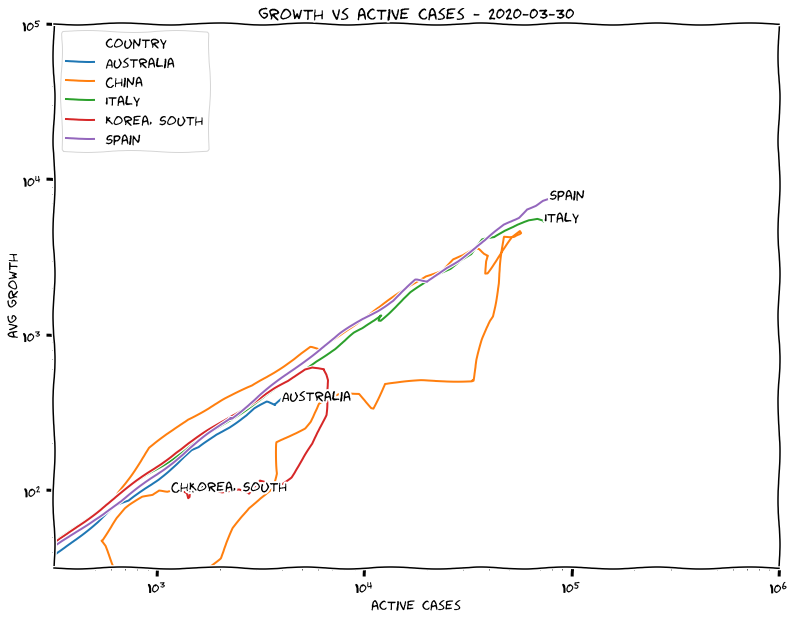

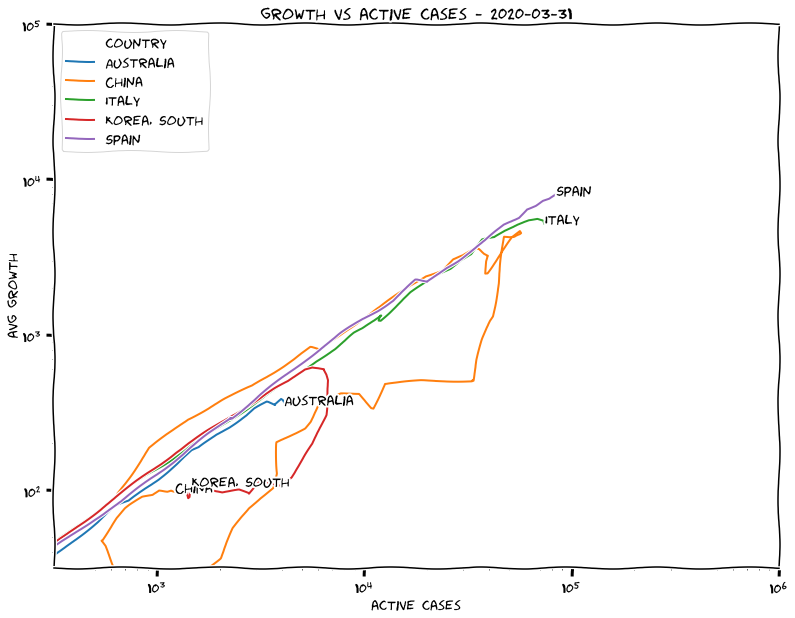

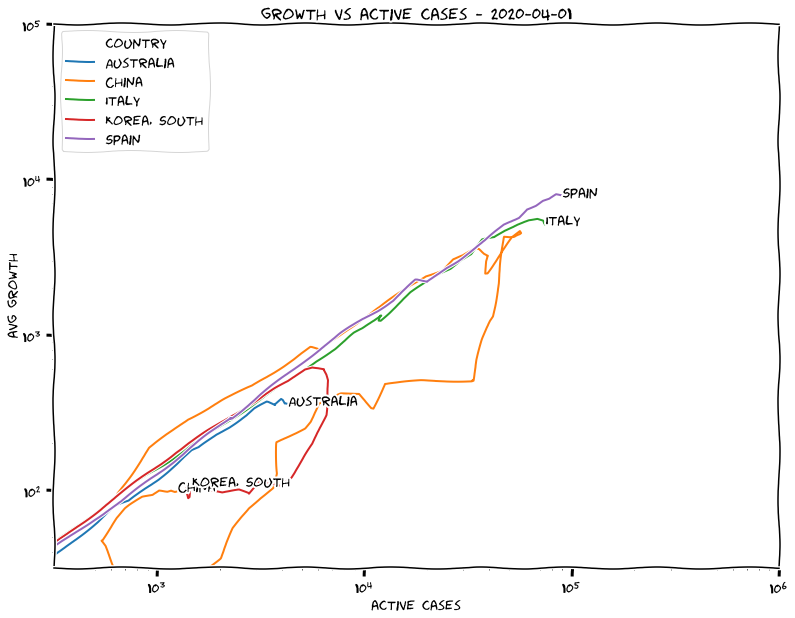

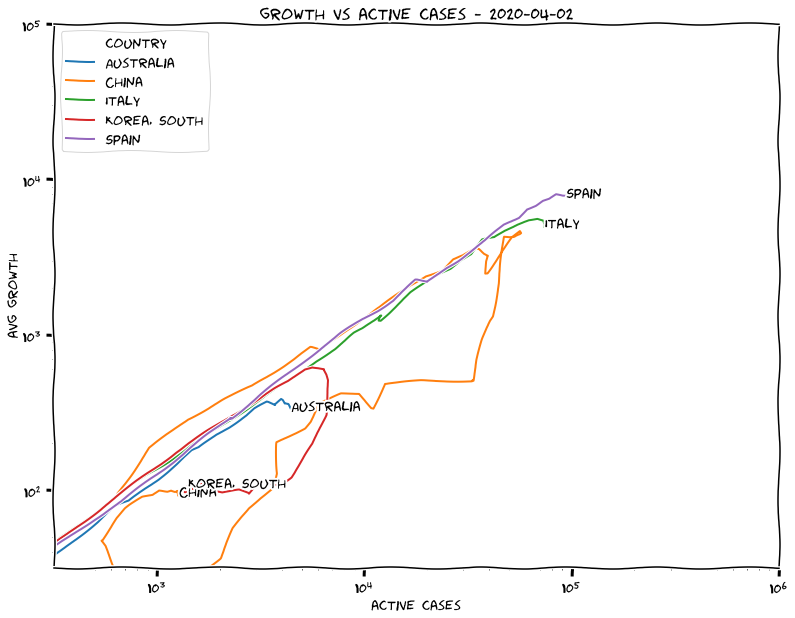

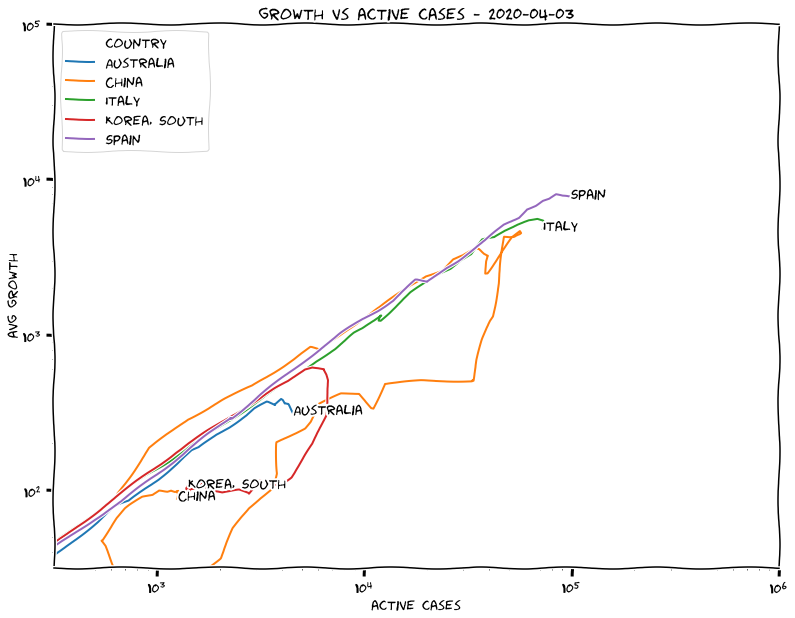

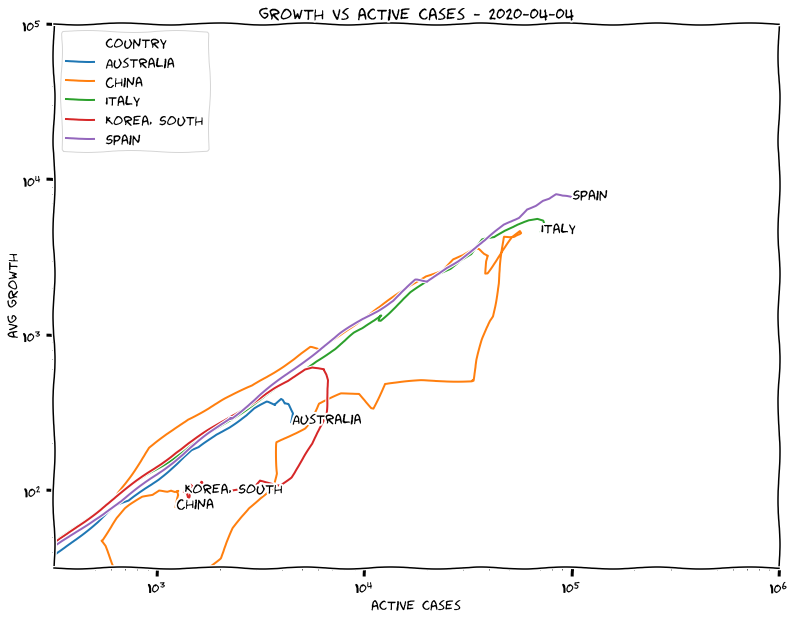

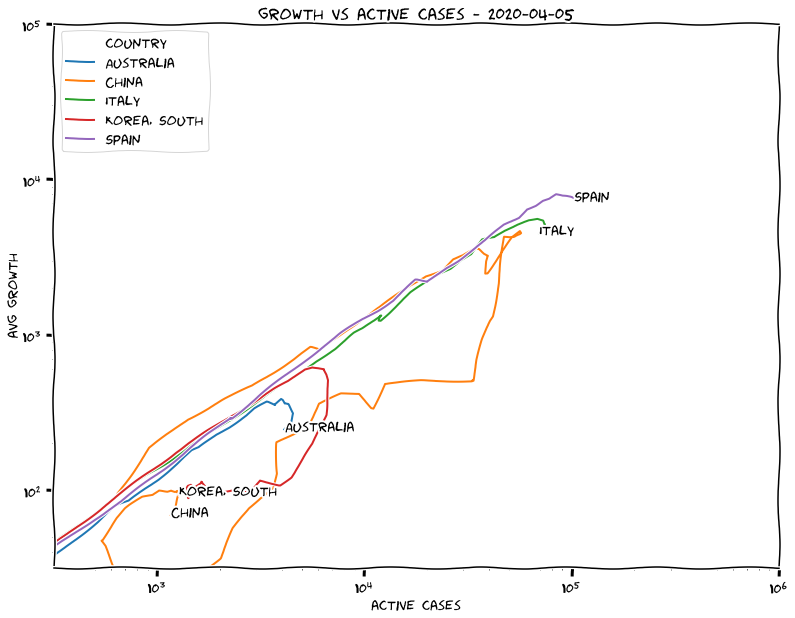

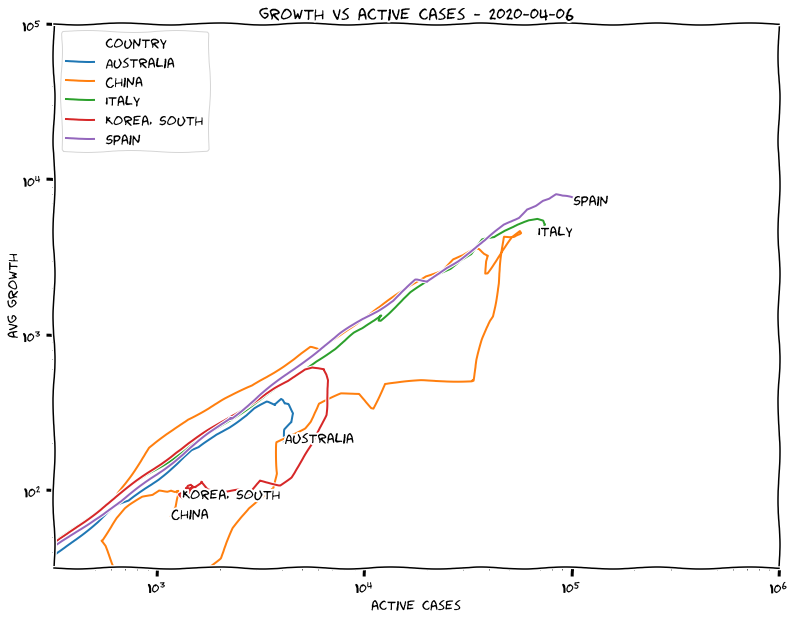

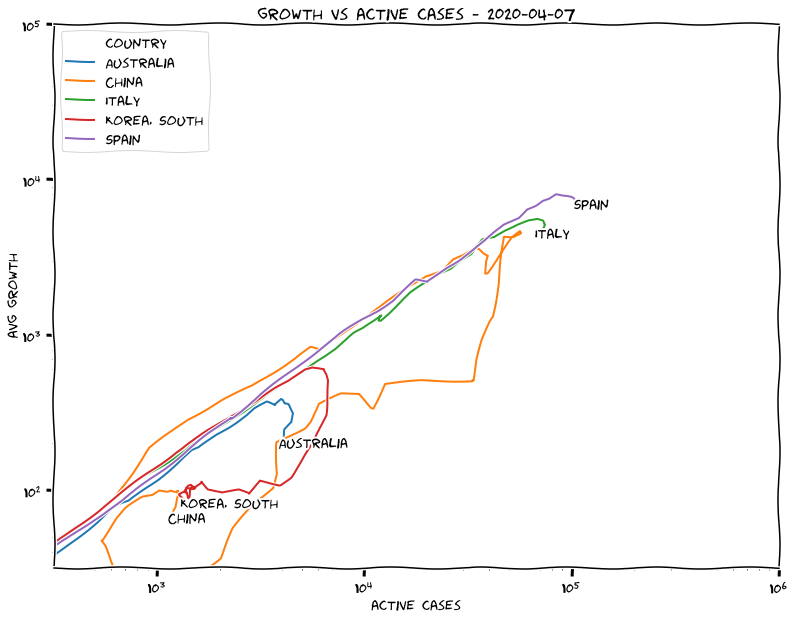

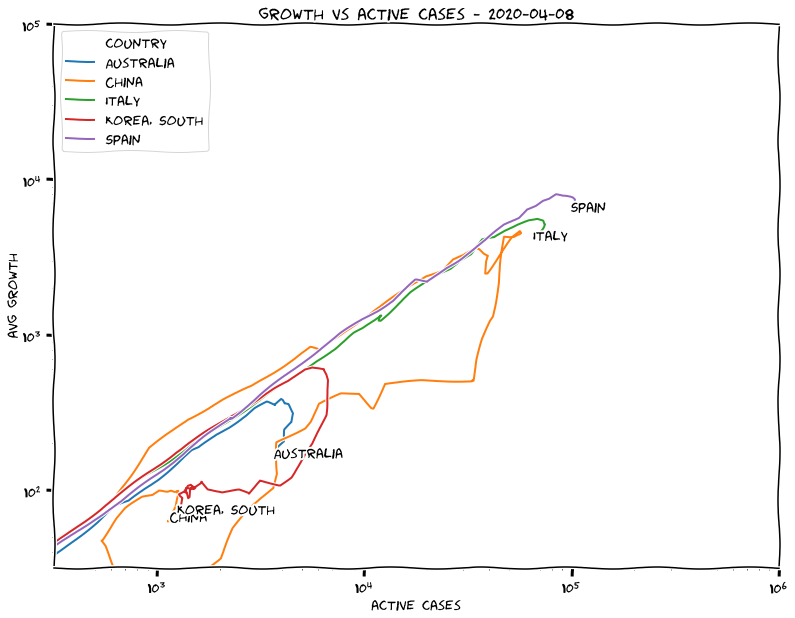

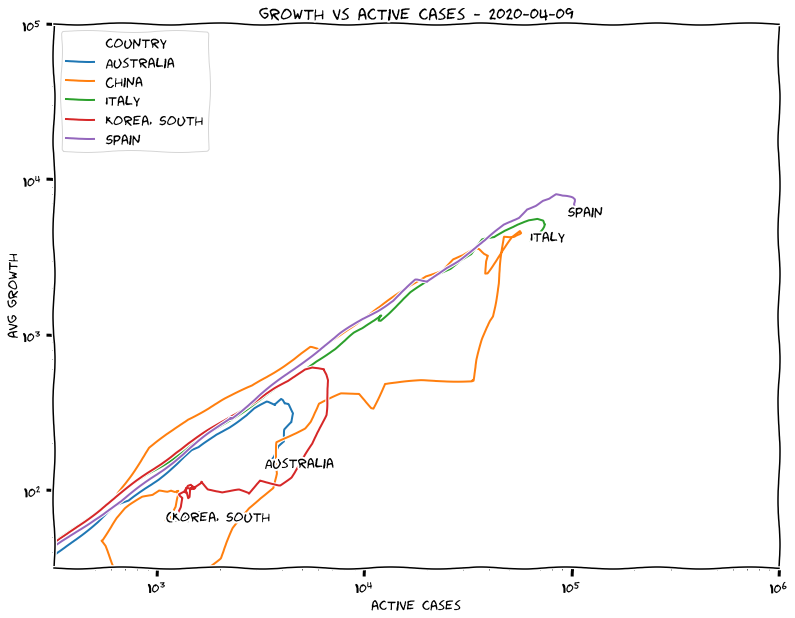

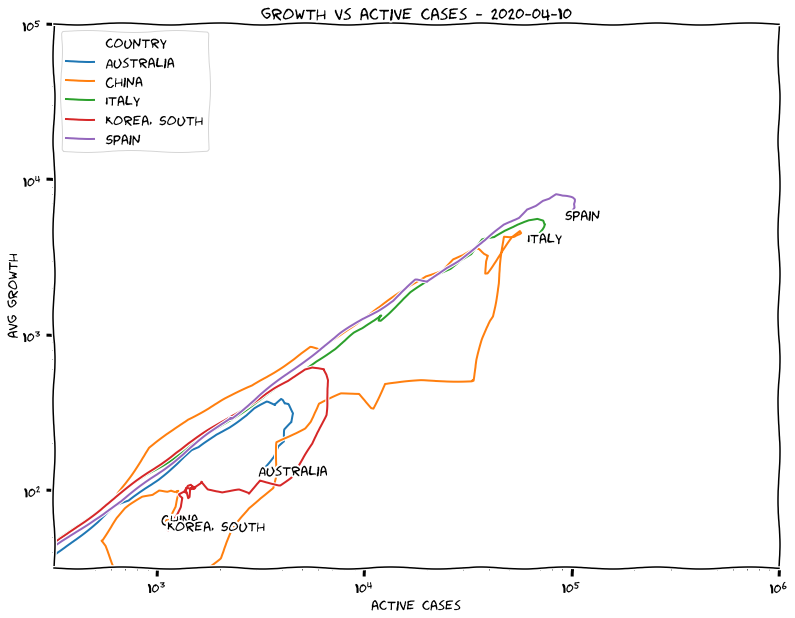

In [89]:
i = 0
for d in w["date"].unique():
    i += 1
    # logPlot('growth vs total cases - ' + str(pd.to_datetime(d).date()) ,'figs/gif/world-'+str(i)+'.png',w[w['date']<=d],'country','total cases','avg growth',False,[10**2.5,10**6],[10**1.5,10**5])
    logPlot(
        "growth vs active cases - " + str(pd.to_datetime(d).date()),
        "figs/activegif/world-active-" + "%02d" % i + "-.png",
        w[
            (w["date"] <= d)
            & (
                w["country"].isin(
                    ["Spain", "Italy", "China", "Australia", "Korea, South"]
                )
            )
        ],
        "country",
        "active cases",
        "avg growth",
        False,
        [10 ** 2.5, 10 ** 6],
        [10 ** 1.5, 10 ** 5],
    )